# 0.0 Imports

In [1]:
import scikitplot as skplt
import xgboost    as xgb
import pandas     as pd
import boruta     as bt
import numpy      as np

import pickle
import random
import inflection

import pandas   as pd # Connect database
import psycopg2 as pg # Connect database

import seaborn as sns

from IPython.display      import Image
from IPython.display      import HTML
from tabulate             import tabulate

from matplotlib import pyplot as plt

from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from scipy   import stats           as ss

import warnings
warnings.filterwarnings('ignore')

/home/work/.pyenv/versions/3.8.0/envs/HealthInsurance/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

## 0.1 Helper Function

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
# Compute a simple cross tabulation of two (or more) factors. By default computes a frequency table of the factors unless an array of values and an aggregation function are passed. https://pandas.pydata.org

# In statistics, Cramér's V (sometimes referred to as Cramér's phi and denoted as φc) is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946. https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2/ (n - 1) 
    rcorr = r - (r - 1) ** 2/ (n - 1) 
    
    v = np.sqrt((chi2corr / n) / (min(kcorr - 1,rcorr - 1)))
    return v   

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict = {}

    for i in range(len(cat_attributes_list)):
        corr_list = []
        for j in range(len(cat_attributes_list)):
            ref  = cat_attributes_list[i] # reference
            feat = cat_attributes_list[j] # feature
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref] = corr_list
    return corr_dict

In [5]:
# precision at k is the proportion of recommended items in the top-k set that are relevant
# (# of our recommendations tha are relevant)/(# of items we recommended)
def precision_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()      
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [6]:
# Recall at k is the proportion of relevant items found in the top-k recommendations
# (# of our recommendations that are relevant)/ (# of all the possible relevant items)
def recall_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()  
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    #data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [7]:
# In classification tasks with imbalanced class distributions we should prefer stratifiedkfold over kfold, because the class distributions is preserved in the splits.

#def cross_validation(data, models_performance, num_folds, modelName, model, x_train, y_train, k):
def cross_validation(data, num_folds, modelName, model, x_train, y_train, k):
    
    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)
    
    precision_list = []
    recall_list = []
    #f1_score_list = []
    #roc_list = []
    
    i = 1
    for train_cv,val_cv in kfold.split(x_train, y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        precision = round(precision_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        precision_list.append(precision)
        
        recall = round(recall_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        recall_list.append(recall)
        
    
    precision_str = np.round(np.mean(precision_list), 3).astype(str) + ' +/- ' + np.round(np.std(precision_list), 3).astype(str)
    recall_str    = np.round(np.mean(recall_list), 3).astype(str)    + ' +/- ' + np.round(np.std(recall_list), 3).astype(str)
    # there are others ranking metrics like F1-Score and Average precision but little used.
    
        
    #models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str], index = models_performance.columns), ignore_index = True)

    #return models_performance
    return {'Model Name': modelName, 'Precision_at_k': precision_str, 'Recall_at_k': recall_str}

In [8]:
b_blue = '#004C99'
o_orange = '#CC6600'

## 0.2 Load dataset

In [9]:
HOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
PORT = '5432'
DATABASE = 'comunidadedsdb'
USER = 'member'
PASSWORD ='cdspa'

conn = pg.connect(host=HOST,
                  database=DATABASE,
                  port=PORT,
                  user=USER,
                  password=PASSWORD)

query = """
    SELECT *
    FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
                       INNER JOIN pa004.insurance i ON (u.id = i.id)
"""

data = pd.read_sql(query, conn)

In [10]:
data.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [11]:
data.to_csv('../data/raw/train.csv', index=False)

In [12]:
df_raw = pd.read_csv('../data/raw/train.csv')

In [13]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,id.1,driving_license,vehicle_age,vehicle_damage,id.2,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [14]:
df_raw = df_raw.drop(df_raw.columns[[5, 9]], axis = 1)
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


# 1.0 Data Description

In [15]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [16]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

### 1.1.1 Features Description

<ul>
    <li><b>id:</b> Customer identifier</li>
    <li><b>gender:</b> Gender of customer</li>
    <li><b>age:</b> Age of customer</li>
    <li><b>region_code:</b> Region code of customer</li>
    <li><b>policy_sales_channel:</b> anonymous code for contact with customer.</li>
    <li><b>previously_insured:</b> 0 if customer does not have a vehicle insurance; 1 if customer already has a vehicle insurance.</li>
     <li><b>annual_premium:</b> amount paid for health insurance to the company anualy.</li>
     <li><b>vintage:</b> time (in days) that customer bought his health assurance.</li>
    <li><b>driving_license:</b> 0 if customer does not have the permission for drive; 1 if customer has the permission for driveRegion</li>
    <li><b>vehicle_age:</b> Age of vehicle</li>
    <li><b>vehicle_damage:</b> 0 if customer never got involved in a previous vehicle damage; 1 if customer already had a vehicle damage</li>
    <li><b>response:</b> 0 if customer has no interest in product; 1 if customer has interest in product</li></ul>

## 1.2 Data Dimensions

In [17]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 381109
Number of Cols: 12


## 1.3 Data Types

In [18]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [19]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5 Fillout NA

## 1.6 Change Types

In [20]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.7 Descriptive Statistics

In [21]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]
cat_attributes = df1[['gender', 'region_code', 'policy_sales_channel', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

### 1.7.1 Numerical Attributes

In [22]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
d2 = pd.DataFrame(num_attributes.apply(min)).T 
d3 = pd.DataFrame(num_attributes.apply(max)).T 
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


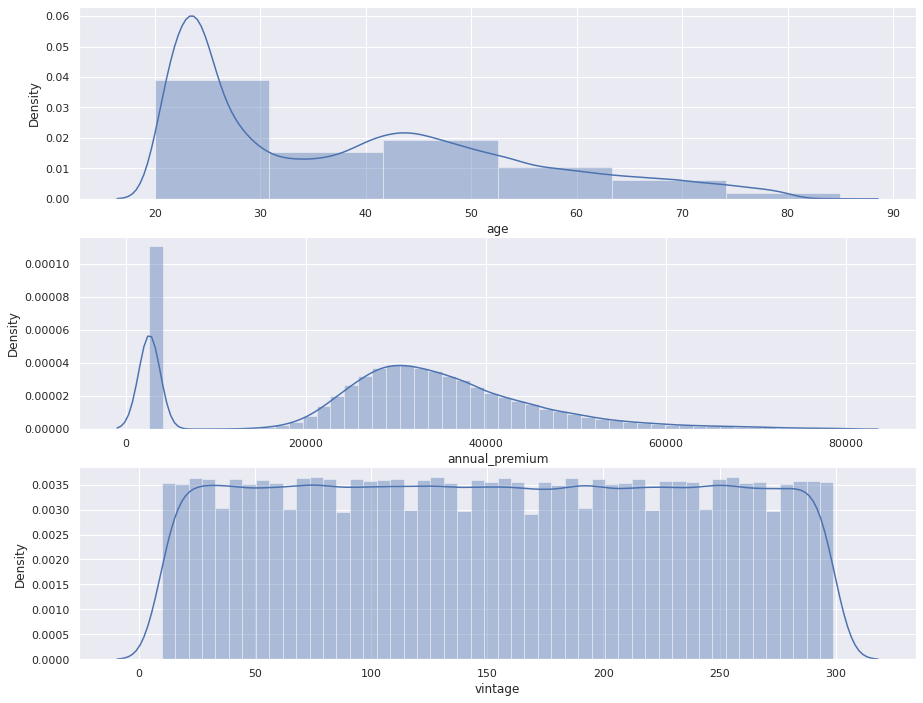

In [23]:
fig, axs = plt.subplots(3, figsize = (15,12))
sns.distplot(df1['age'], ax = axs[0], bins = 6)
sns.distplot(df1[df1['annual_premium'] < 80000]['annual_premium'], ax = axs[1])
sns.distplot(df1['vintage'], ax = axs[2]);


### 1.7.2 Categorical Attributes

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
previously_insured        2
response                  2
dtype: int64

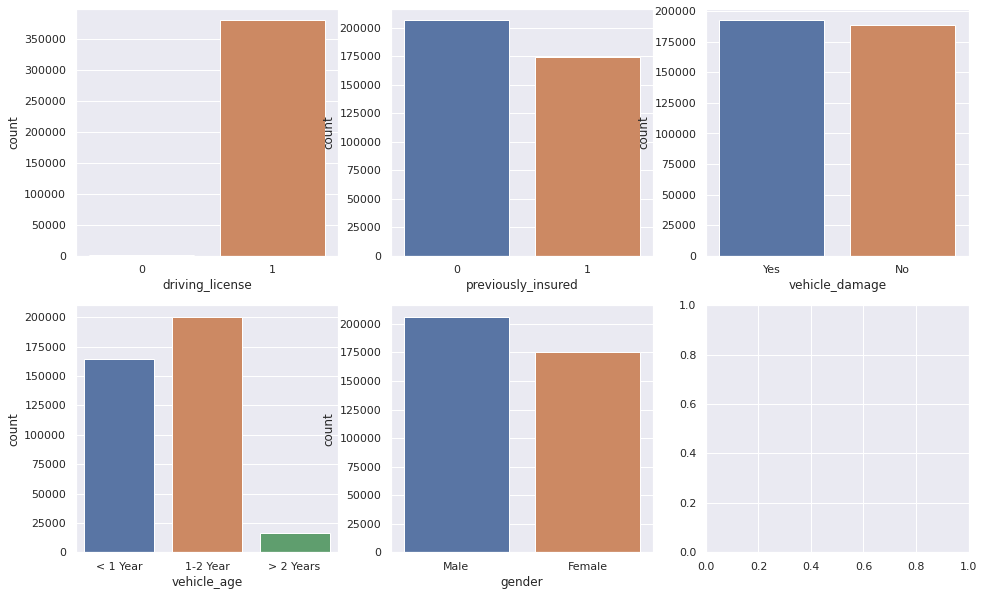

In [25]:
fig, axs = plt.subplots(ncols = 3, nrows = 2,  figsize = (16, 10))
sns.countplot(x = 'driving_license', data = df1, ax = axs[0][0])
sns.countplot(x = 'previously_insured', data = df1, ax = axs[0][1])
sns.countplot(x = 'vehicle_damage', data = df1, ax = axs[0][2])
sns.countplot(x = 'vehicle_age', data = df1, ax = axs[1][0])
sns.countplot(x = 'gender', data = df1, ax = axs[1][1]);

In [26]:
driving_license_perc = (df1['driving_license'].sum()) / (df1.shape[0])
driving_license_perc = "{0:.2f}%".format(driving_license_perc * 100)
print (f'Percentage of Licensed drivers: {driving_license_perc}')

previously_insured_perc = (df1['previously_insured'].sum()) / (df1.shape[0])
driving_license_perc = "{0:.2f}%".format(previously_insured_perc * 100)
print (f'Percentage of Previously Insured customers: {driving_license_perc}')

vehicle_damage_perc = df1['vehicle_damage'][df1['vehicle_damage'] == 'Yes'].value_counts() / (df1.shape[0])
vehicle_damage_perc = "{0:.2f}%".format(vehicle_damage_perc[0] * 100)
print (f'Percentage of Vehicle Damage: {vehicle_damage_perc}')

vehicle_age_perc = df1['vehicle_age'].value_counts() / (df1.shape[0])
print ('Cars with less than 1 year old: ' "{0:.2f}%".format(vehicle_age_perc[0] * 100))
print ('Cars with age between 1 and 2 years old: ' "{0:.2f}%".format(vehicle_age_perc[1] * 100))
print ('Cars with age higher of 2 years old: ' "{0:.2f}%".format(vehicle_age_perc[2] * 100))

gender_perc = df1['gender'].value_counts() / (df1.shape[0])
print ('Percentage of males: ' "{0:.2f}%".format(gender_perc[0] * 100))
print ('Percentage of females: ' "{0:.2f}%".format(gender_perc[1] * 100))

Percentage of Licensed drivers: 99.79%
Percentage of Previously Insured customers: 45.82%
Percentage of Vehicle Damage: 50.49%
Cars with less than 1 year old: 52.56%
Cars with age between 1 and 2 years old: 43.24%
Cars with age higher of 2 years old: 4.20%
Percentage of males: 54.08%
Percentage of females: 45.92%


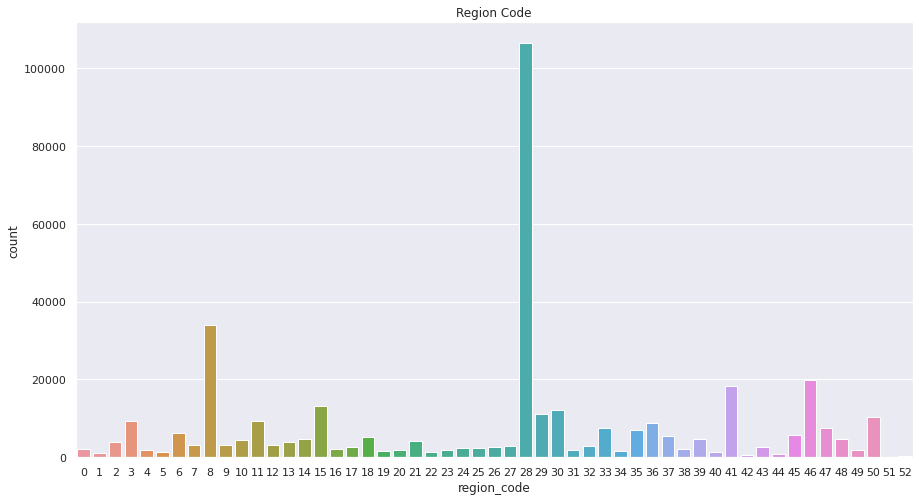

In [27]:
fig = plt.subplots(figsize = (15,8))
sns.countplot(x = 'region_code', data = df1).set_title('Region Code');

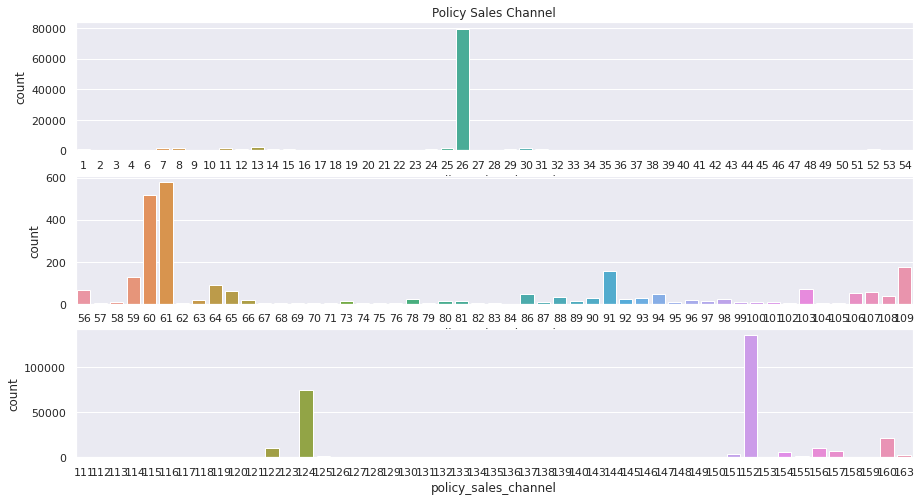

In [28]:
policy_1 = df1[(df1['policy_sales_channel'] > 0)  & (df1['policy_sales_channel'] < 55)]
policy_2 = df1[(df1['policy_sales_channel'] > 55) & (df1['policy_sales_channel'] < 110)]
policy_3 = df1[df1['policy_sales_channel']  > 110]

fig, axs = plt.subplots(nrows = 3,  figsize = (15,8))
sns.countplot(x = 'policy_sales_channel', data = policy_1, ax = axs[0]).set_title('Policy Sales Channel')
sns.countplot(x = 'policy_sales_channel', data = policy_2, ax = axs[1])
sns.countplot(x = 'policy_sales_channel', data = policy_3, ax = axs[2]);

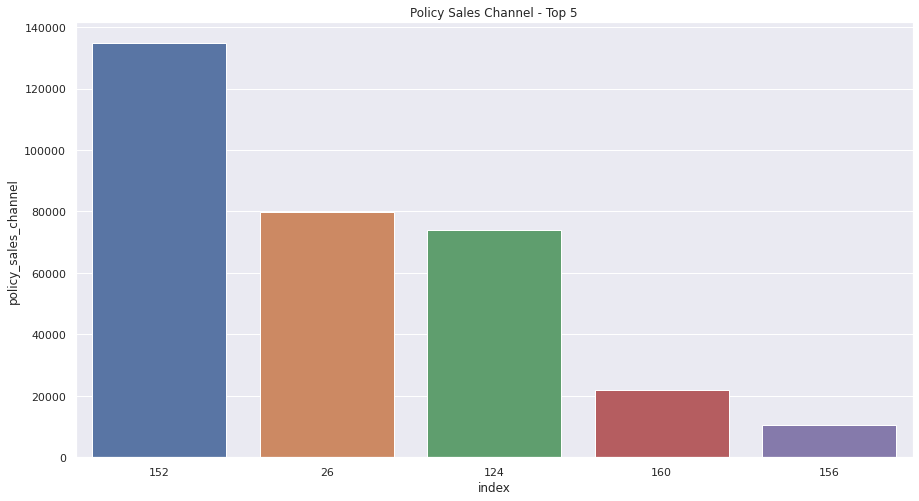

In [29]:
top_sales_channel = df1['policy_sales_channel'].value_counts().reset_index().sort_values('policy_sales_channel', ascending = False)
top5_sales_channel = top_sales_channel[top_sales_channel['policy_sales_channel'] > 10000]

fig = plt.subplots(figsize = (15,8))
sns.barplot(y = 'policy_sales_channel', x = 'index', data = top5_sales_channel, order = top5_sales_channel['index']).set_title('Policy Sales Channel - Top 5');

In [30]:
most_used_channels_perc = (top5_sales_channel['policy_sales_channel'].sum()) / (df1.shape[0])
most_used_channels_perc = "{0:.2f}%".format(most_used_channels_perc * 100)
print (f'Most 5 used channels represent {most_used_channels_perc} of all channels.')

Most 5 used channels represent 84.21% of all channels.


### 1.7.3 Response variable

In [31]:
response_perc = df1['response'].value_counts() / (df1.shape[0])
print ('Not interested customers: ' "{0:.2f}%".format(response_perc[0] * 100))
print ('Interested customers: ' "{0:.2f}%".format(response_perc[1] * 100))

Not interested customers: 87.74%
Interested customers: 12.26%


### 1.7.4 Description Summary

<h3>For numerical attributes:</h3>
<ol>
    <li>
        <strong>Age</strong>
            <ul>
                <li>Range: 20 to 85 years old;</li>
                <li>Mean: 38.52 years old;</li>
                <li>Median: 36 years old;</li>
            </ul>
    </li>
    <br>
    <li>
        <strong>Annual_premium</strong>
            <ul>
                <li>Range: 2630 to 540165;</li>
                <li>There is a peak in 2630, and a high density around 20000 to 60000.</li>
            </ul>
    </li>
    <br>
    <li>
        <strong>Vintage</strong>
            <ul>
                <li>Range: 10 to 299 days;</li>
                <li>Mean: 154.347397 days;</li>
                <li>Median: 154 days.</li>
            </ul>
     </li>
</ol>

<h3>For categorical attributes:</h3>
<ol>
    <li>
        <strong>Driving License</strong>
            <ul>
                <li>Percentage of Licensed drivers: 99.79%.</li>               
            </ul>
    </li>
    <br>
    <li>
        <strong>Previously Insured</strong>
            <ul>
                <li>Percentage of Previously Insured customers: 45.82%.</li>
            </ul>
    </li>
    <br>
    <li>
        <strong>Vehicle Damage</strong>
            <ul>
                <li>Percentage of Vehicle Damage: 50.49%.</li>                
            </ul>
    </li>
    <br>
    <li>
        <strong>Vehicle Age</strong>
            <ul>
                <li>Cars with less than 1 year old: 52.56%,</li>
                <li>Cars with age between 1 and 2 years old: 43.24%,</li>
                <li>Cars with age higher of 2 years old: 4.20%.</li>
            </ul>
    </li>
    <br>
    <li>
        <strong>Gender</strong>
            <ul>
                <li>Males: 54.08%</li>
                <li>Females: 45.92%</li>                     
            </ul>
    </li>
    <br>
    <li>
        <strong>Region Code</strong>
            <ul>
                <li>53 regions</li>
           </ul>    
    </li>
    <br>
    <li>
        <strong>Policy Sales Channel</strong>
            <ul>
                <li>155 different channels,</li>
                <li>Most 5 used channels represents 84.21% of all channels.</li>
           </ul>    
    </li>
</ol>

<h3>For response variable:</h3>
<ul>
    <li> Not interested customers: 87.74%</li>
    <li> Interested customers: 12.26%</li>
</ul>

In [32]:
df1.to_pickle(r"../data/interim/df1.pkl")#, index=False)

# 2.0. Feature Engineering

In [33]:
#df2 = pd.read_csv('../data/interim/df1.csv')
#df2.to_pickle(r"../data/interim/df2.pkl")
df2 = pd.read_pickle(r"../data/interim/df1.pkl")

## 2.1 Mental Map Hyphotesis

In [34]:
Image('../figures/hyphotesis_map.png')

FileNotFoundError: No such file or directory: '../figures/hyphotesis_map.png'

FileNotFoundError: No such file or directory: '../figures/hyphotesis_map.png'

<IPython.core.display.Image object>

## 2.2 Hyphotesis Criation

### 2.2.1 Customer Hypotheses
**1.** Women are more likely to take out car insurance.<br>
**2.** The older the age, the greater the possibility of taking out car insurance.<br>
**3.** The place of residence influences the decision to take out car insurance.<br>
**4.** Married people are more likely to take out car insurance.<br>
**5.** People with children are more likely to buy car insurance.<br>

### 2.2.2 Vehicle Hypotheses
**1.** People who have had damage to their cars are more likely to take out car insurance.<br>
**2.** People who already have car insurance are more likely to purchase a new policy.<br>
**3.** People with newer vehicles are more likely to take out car insurance.<br>
**4.** People who use their car more frequently are more likely to take out car insurance.<br>

### 2.2.3 Insurance Company Hypotheses
**1.** Clients with an older relationship with the insurance company are more likely to contract a new product.<br>
**2.** Customers with higher health insurance expenses are more likely to purchase a new product.<br>

## 2.3 Final Hyphotesis List

**1.** Women are more likely to take out car insurance.<br>
**2.** The older the age, the greater the possibility of taking out car insurance.<br>
**3.** The place of residence influences the decision to take out car insurance.<br>
**4.** People who have had damage to their cars are more likely to take out car insurance.<br>
**5.** People who already have car insurance are more likely to purchase a new policy.<br>
**6.** People with newer vehicles are more likely to take out car insurance.<br>
**7.** Clients with an older relationship with the insurance company are more likely to contract a new product.<br>
**8.** Customers with higher health insurance expenses are more likely to purchase a new product.<br>

## 2.4 Feature Engineering

In [35]:
# Vehicle Damage Number - Binary Categorical -> Binary Numeric
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 
                                                 1 if x == 'Yes' else
                                                 0)

# Vehicle Age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x:
                            'over_2_years' if x == '> 2 Years' else
                        'between_1_2_year' if x == '1-2 Year'  else
                            'below_1_year')

# Gender
df2['gender'] = df2['gender'].apply( lambda x: 1 if x == 'Female' else 0)

In [36]:
# Creating Damage per region code index
damage_per_rcode = df2[['vehicle_damage']].groupby(df2['region_code']).mean().reset_index()
damage_per_rcode = damage_per_rcode.rename( columns = {'vehicle_damage' : 'damage_per_rcode'})
df2 = df2.merge(damage_per_rcode, on = 'region_code', how = 'left')
df2['damage_per_rcode'] = df2['damage_per_rcode'].astype('float64')

In [37]:
#df2.to_csv('../data/interim/df2.csv', index=False)
df2.to_pickle(r"../data/interim/df2.pkl")

# 3.0. Data Filtering

In [38]:
# df3 = pd.read_csv('../data/interim/df2.csv')
df3 = pd.read_pickle(r"../data/interim/df2.pkl")

## 3.1 Row Filtering

## 3.2 Column Filtering

In [39]:
# df3.to_csv('../data/interim/df3.csv', index=False)
df3.to_pickle(r"../data/interim/df3.pkl")

In [40]:
# to test the api in heroku
df3.to_csv('../data/interim/df_teste.csv', index=False)

# 4.0. Exploratory Data Analysis

In [41]:
# df4 = pd.read_csv('../data/interim/df3.csv')
df4 = pd.read_pickle(r"../data/interim/df3.pkl")

## 4.1. Univariate Analysis

We need to find variates that are separate in relation to response variable, so these variables helps the algorithm to classificate the data in a better way.

If we have variables that merge some behavior of the features, these variables will not help the algorithm.

In [42]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'damage_per_rcode'],
      dtype='object')

### 4.1.1 Response Variable

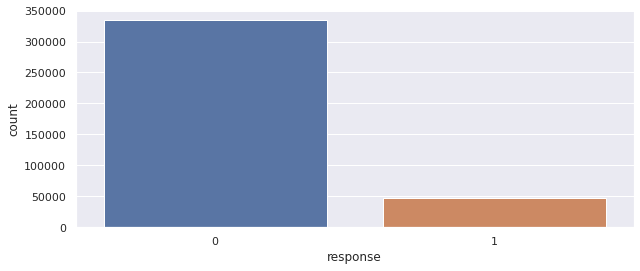

In [43]:
fig = plt.subplots(figsize = (10,4))
sns.countplot('response', data = df4);

### 4.1.2 Numerical Variable

#### 4.1.2.1 Age

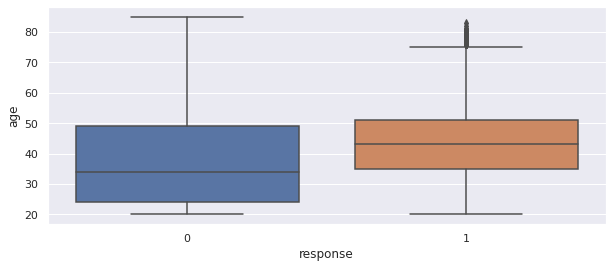

In [44]:
fig = plt.subplots(figsize = (10,4))
sns.boxplot(x = 'response', y = 'age', data = df4);

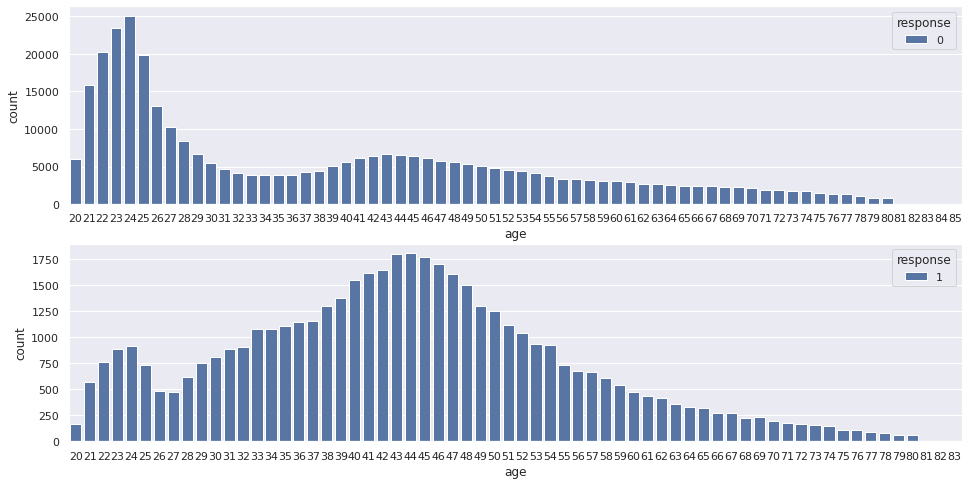

In [45]:
fig, axs = plt.subplots(nrows = 2, figsize = (16,8))
sns.countplot(x = 'age', data = df4[df4['response'] == 0], hue = 'response', ax = axs[0]);
sns.countplot(x = 'age', data = df4[df4['response'] == 1], hue = 'response', ax = axs[1]);

#### 4.1.2.9 Annual Premium

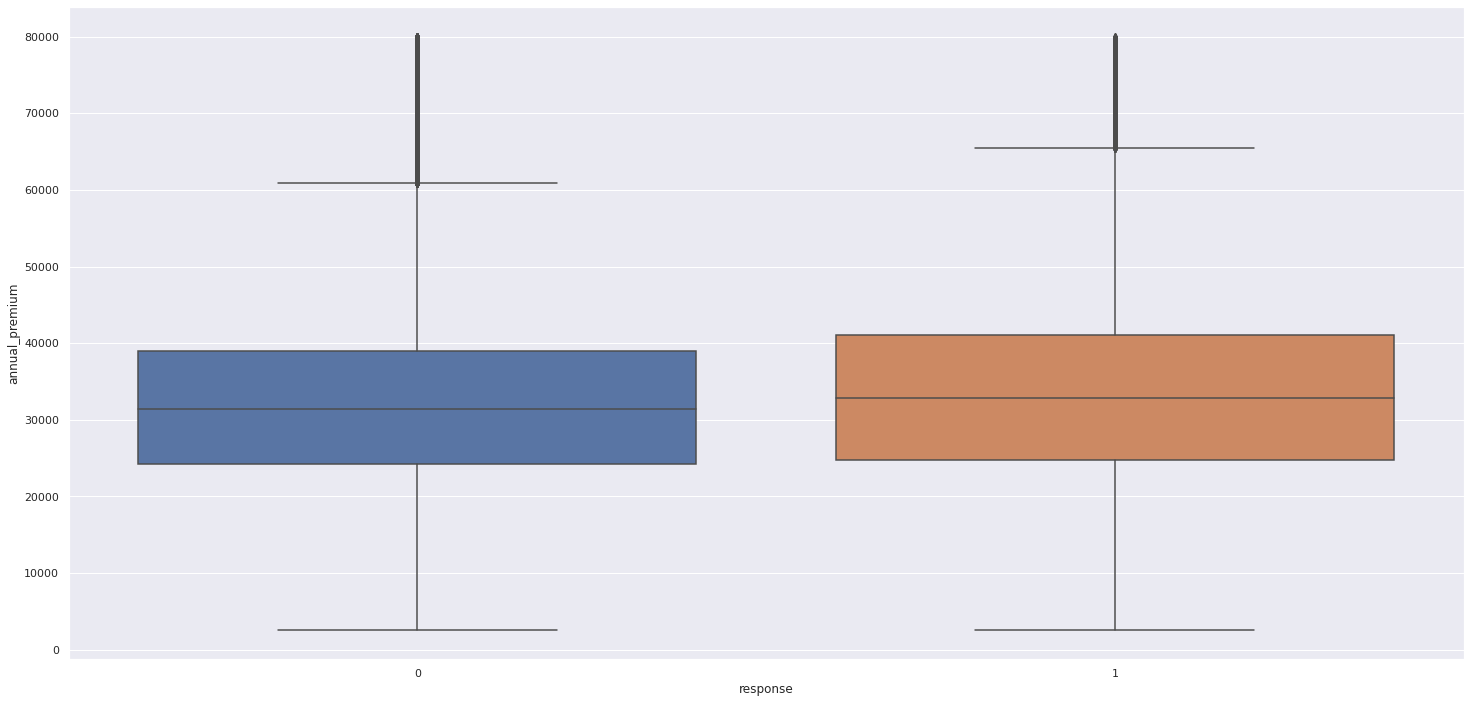

In [46]:
ann_pre = df4[df4['annual_premium'] < 80000]
sns.boxplot(x = 'response', y = 'annual_premium', data = ann_pre);

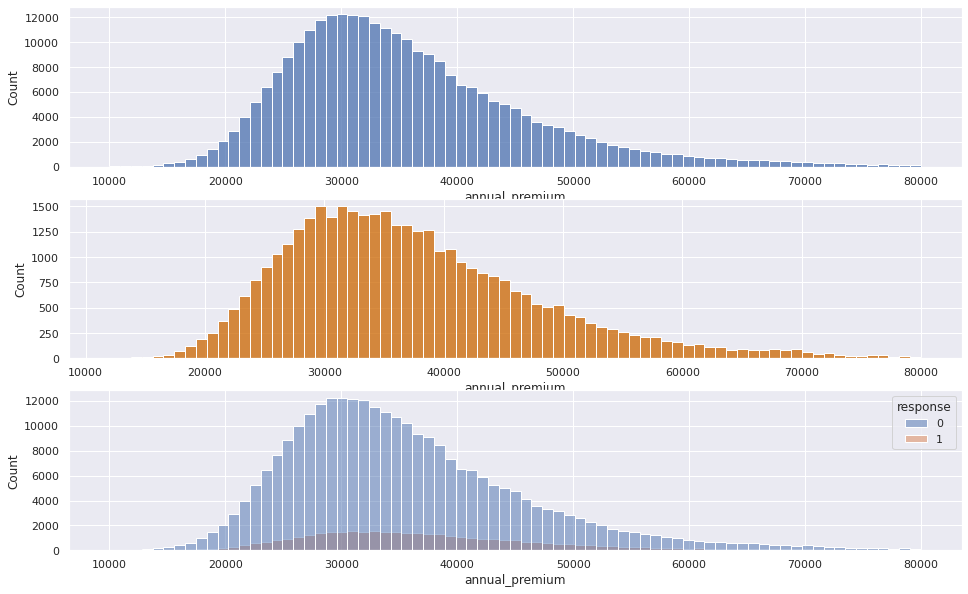

In [47]:
range_10_80 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
num_no = range_10_80.loc[range_10_80['response'] == 0, 'annual_premium']

num_yes = range_10_80.loc[range_10_80['response'] == 1, 'annual_premium']

fig, axs = plt.subplots(nrows = 3, figsize = (16,10))

sns.histplot(num_no, bins = 75, ax = axs[0])
sns.histplot(num_yes, bins = 75, ax = axs[1], color = o_orange)
sns.histplot(range_10_80, x = 'annual_premium', hue = 'response', bins = 75, ax = axs[2]);

#### 4.1.2.10 Vintage

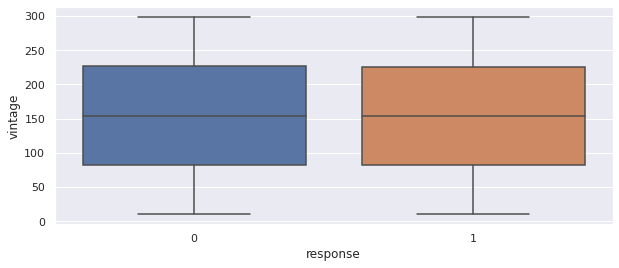

In [48]:
fig = plt.subplots(figsize = (10,4))
sns.boxplot(x = 'response', y = 'vintage', data = df4);

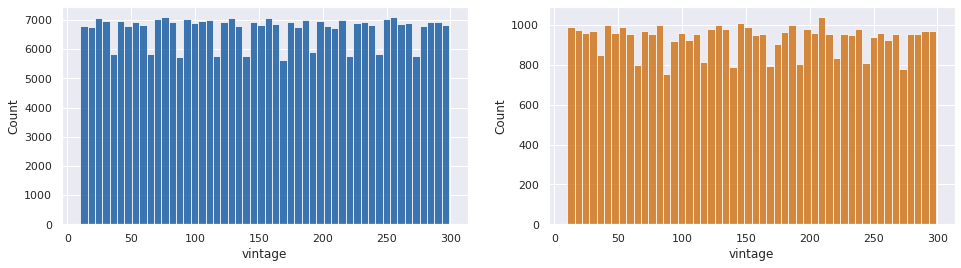

In [49]:
vint_no = df4.loc[df4['response'] == 0, 'vintage']
vint_yes = df4.loc[df4['response'] == 1, 'vintage']

fig, axs = plt.subplots(ncols = 2, figsize = (16,4))

sns.histplot(vint_no, bins = 50, ax = axs[0], color = b_blue);
sns.histplot(vint_yes, bins = 50, ax = axs[1], color = o_orange);

### 4.1.3 Categorical Variable

#### 4.1.2.4 Policy Sales Channel

For 2nd cycle implement stacked percentage bar chart

In [50]:
pol_sal_no = df4[df4['response'] == 0]
pol_sal_no = pol_sal_no[['policy_sales_channel', 'response']].groupby('policy_sales_channel').count()
pol_sal_no.head()

,response
policy_sales_channel,
1,1039
2,3
3,364
4,407
6,3


In [51]:
pol_sal_yes = df4[df4['response'] == 1]
pol_sal_yes = pol_sal_yes[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum()
pol_sal_yes.head()

,response
policy_sales_channel,
1,35
2,1
3,159
4,102
7,182


In [52]:
pol_sal = pd.merge(pol_sal_no, pol_sal_yes, how = 'inner', on = 'policy_sales_channel')

pol_sal = pol_sal.rename(columns = {'policy_sales_channel': 'policy_sales_channel', 'response_x':'response_0', 'response_y':'response_1'})

pol_sal['total_responses'] = df4[['id', 'policy_sales_channel']].groupby('policy_sales_channel').size()

pol_sal['perc_response_1'] = (pol_sal['response_1']/pol_sal['total_responses'])*100
pol_sal = pol_sal.reset_index()
pol_sal.head()

,policy_sales_channel,response_0,response_1,total_responses,perc_response_1
0,1,1039,35,1074,3.258845
1,2,3,1,4,25.000000
2,3,364,159,523,30.401530
3,4,407,102,509,20.039293
4,7,1416,182,1598,11.389237


In [53]:
pol_sal_1000 = pol_sal[pol_sal['total_responses'] >= 1000]
pol_sal_1000.sort_values(['perc_response_1'], ascending=False)

,policy_sales_channel,response_0,response_1,total_responses,perc_response_1
112,155,839,395,1234,32.009724
118,163,2013,880,2893,30.418251
114,157,4890,1794,6684,26.840215
111,154,4519,1474,5993,24.595361
113,156,8364,2297,10661,21.545821
22,25,1479,369,1848,19.967532
23,26,63809,15891,79700,19.938519
90,124,59999,13996,73995,18.914792
89,122,8210,1720,9930,17.321249
45,55,1075,189,1264,14.952532


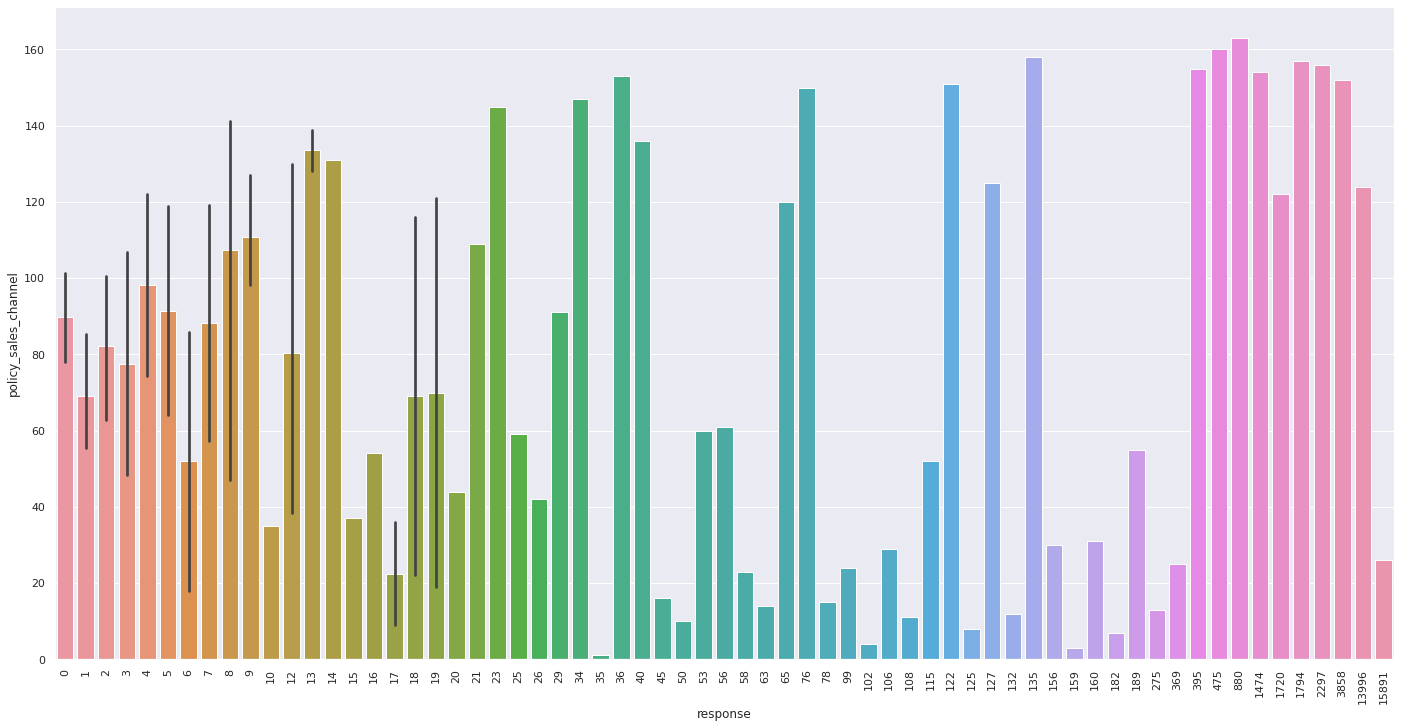

In [54]:
plt.figure(figsize = (24, 12))
pol_sal = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x = 'response', y = 'policy_sales_channel', data = pol_sal)
plt.xticks(rotation=90);

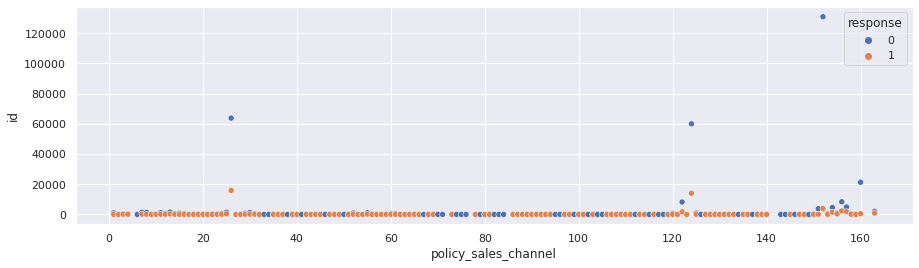

In [55]:
fig, axs = plt.subplots(figsize = (15,4))
pol_sal = df4[['id', 'policy_sales_channel', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()
sns.scatterplot(x = 'policy_sales_channel', y ='id', hue = 'response', data = pol_sal);

#### 4.1.2.6 Vehicle Age

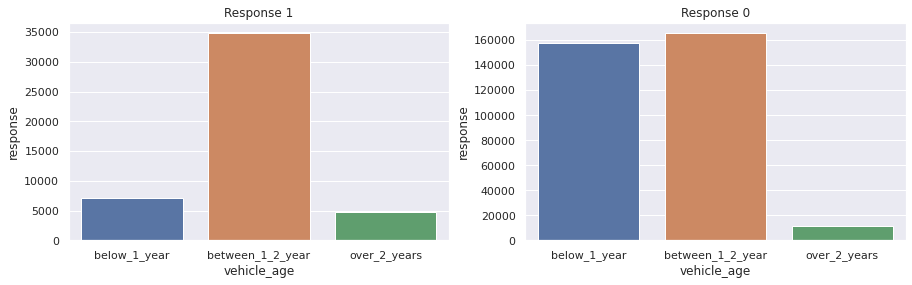

In [56]:
veh_age_1 = df4[df4['response'] == 1].groupby('vehicle_age').count().reset_index()
veh_age_0 = df4[df4['response'] == 0].groupby('vehicle_age').count().reset_index()

fig, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.barplot(x = 'vehicle_age', y = 'response', data = veh_age_1, ax = axs[0]).set_title('Response 1');
sns.barplot(x = 'vehicle_age', y = 'response', data = veh_age_0, ax = axs[1]).set_title('Response 0');

In [57]:
df4[['vehicle_age', 'response']].value_counts(normalize = True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


#### 4.1.2.8 Previously Insured

It need to be careful because this feature can tell to the model that people that already have vehicle insurance will not be interested in the offer of the company, that is not true. 

This would be a data lackage.

In [58]:
df4['previously_insured'].unique()

array([0, 1])

In [59]:
# Contingency table
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum() * 100, axis = 1)

response,0,1
previously_insured,,
0,77.454584,22.545416
1,99.909522,0.090478


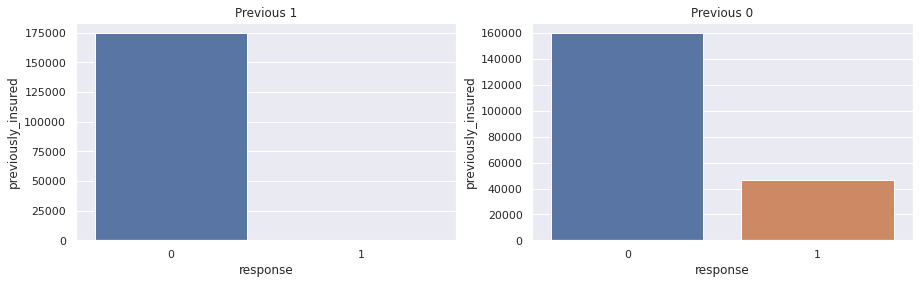

In [60]:
pre_ins_1 = df4[df4['previously_insured'] == 1].groupby('response').count().reset_index()
pre_ins_0 = df4[df4['previously_insured'] == 0].groupby('response').count().reset_index()

fig, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.barplot(x = 'response', y = 'previously_insured', data = pre_ins_1, ax = axs[0]).set_title('Previous 1');
sns.barplot(x = 'response', y = 'previously_insured', data = pre_ins_0, ax = axs[1]).set_title('Previous 0');

#### 4.1.2.7 Vehicle Damage

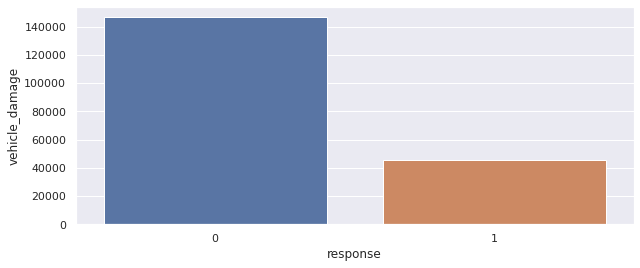

In [61]:
vehi_dam = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
fig = plt.subplots(figsize = (10,4))
sns.barplot(x = 'response', y = 'vehicle_damage', data = vehi_dam);

In [62]:
vehi_dam

,response,vehicle_damage
0,0,146685
1,1,45728


#### Damage per Region Code

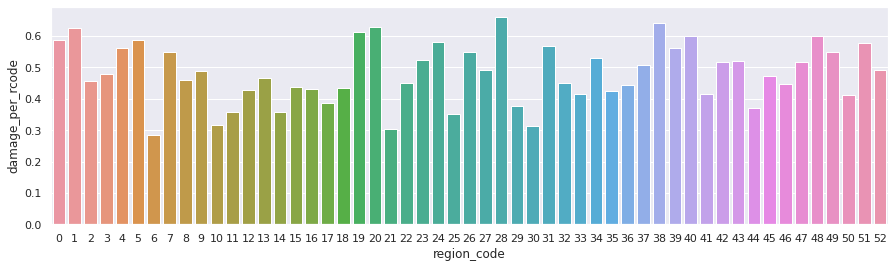

In [63]:
dprc = df4[['region_code', 'damage_per_rcode']]
fig = plt.subplots(figsize = (15,4))
sns.barplot(x = 'region_code', y = 'damage_per_rcode', data = dprc);

#### 4.1.2.3 Region Code

In [64]:
df4['region_code'].unique()

array([11, 15, 35,  8, 28, 39, 29, 30, 25, 22, 36,  0, 26,  6, 48, 47, 33,
       41, 46, 43,  2, 37, 40,  4, 10, 18,  9,  3, 50, 32, 24, 27, 34, 21,
       45, 12,  5, 49, 14, 16, 13, 31, 23,  1, 42,  7, 17, 44, 19, 38, 20,
       52, 51])

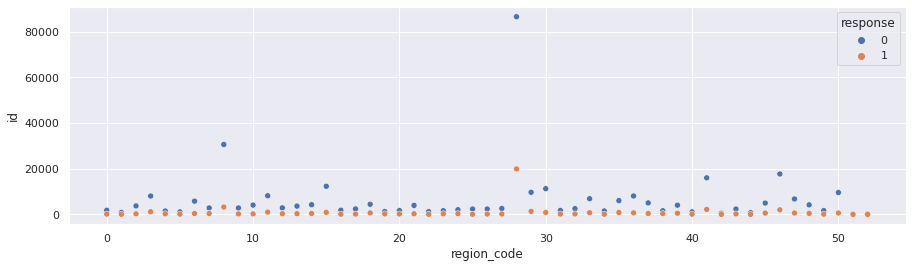

In [65]:
reg_cod = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
fig = plt.subplots(figsize = (15,4))
sns.scatterplot(x = 'region_code', y = 'id', hue = 'response', data = reg_cod);

# region_code x vehicle_damage x previously_insured

#### 4.1.2.2 Gender

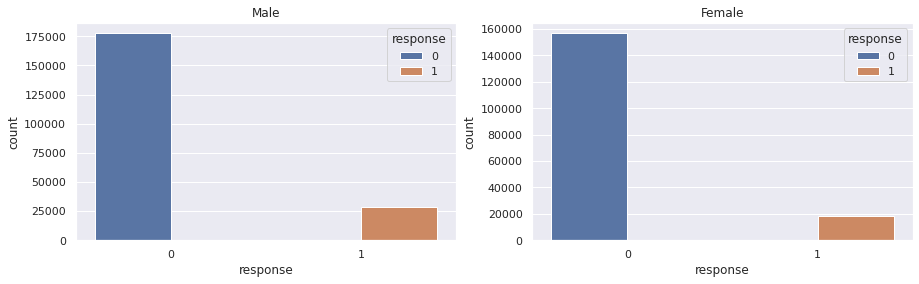

In [66]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(x = 'response', data = df4[df4['gender'] == 0], hue = 'response', ax = axs[0]).set_title('Male');
sns.countplot(x = 'response', data = df4[df4['gender'] == 1], hue = 'response', ax = axs[1]).set_title('Female');

In [67]:
pd.crosstab(df4['gender'], df4['response'])

response,0,1
gender,,
0,177564,28525
1,156835,18185


#### 4.1.2.5 Driving License

In [68]:
df4[['driving_license', 'response']].head()

,driving_license,response
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [69]:
df4['driving_license'].unique()

array([1, 0])

<AxesSubplot:xlabel='response', ylabel='driving_license'>

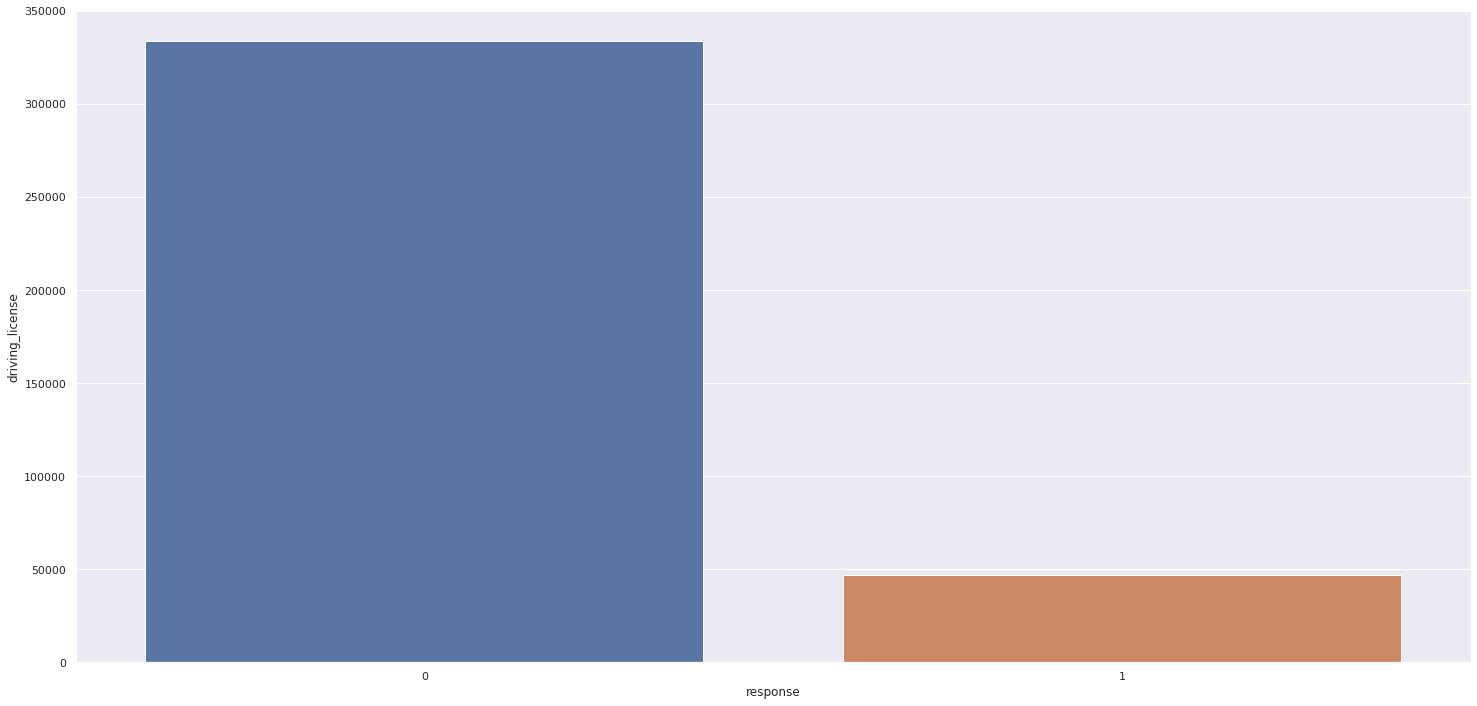

In [70]:
driv_lic = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x = 'response', y = 'driving_license', data = driv_lic)

In [71]:
driv_lic['driving_license_perc'] = driv_lic['driving_license']/driv_lic['driving_license'].sum()
driv_lic

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


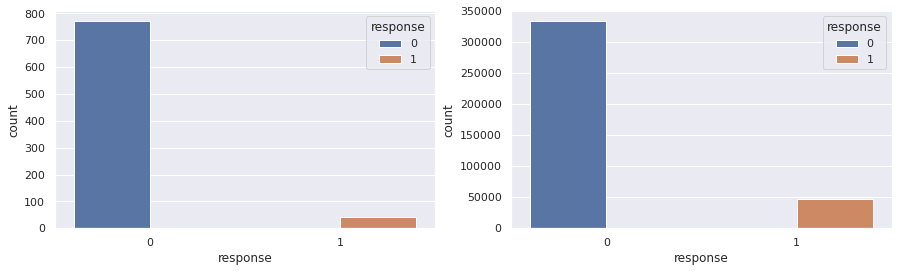

In [72]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(x = 'response', data = df4[df4['driving_license'] == 0], hue = 'response', ax = axs[0]);
sns.countplot(x = 'response', data = df4[df4['driving_license'] == 1], hue = 'response', ax = axs[1]);

In [73]:
pd.crosstab(df4['driving_license'], df4['response'])

response,0,1
driving_license,,
0,771,41
1,333628,46669


## 4.2 Bivariate Analysis

### 4.2.1 Hyphotesis Validation

#### H1: Women are more likely to take out car insurance.

##### The hypothesis is FALSE, the interest among men is higher.

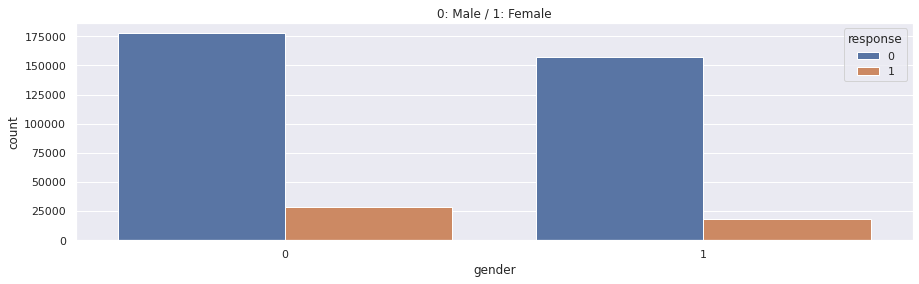

In [74]:
fig, axs = plt.subplots(figsize = (15,4))
sns.countplot(x = df4['gender'], hue = df4['response']).set_title('0: Male / 1: Female');

In [75]:
woman = df4[df4['gender'] == 1].count()
woman_yes = df4[(df4['gender'] == 1) & (df4['response'] == 1)].count()
male = df4[df4['gender'] == 0].count()
male_yes = df4[(df4['gender'] == 0) & (df4['response'] == 1)].count()
woman_yes_perc = (woman_yes['id'] / woman['id']) * 100
male_yes_perc = (male_yes['id'] / male['id']) * 100

print ('The percentage of interest among womans is ' "{0:.2f}%".format(woman_yes_perc))
print ('The percentage of interest among mens is ' "{0:.2f}%".format(male_yes_perc))

The percentage of interest among womans is 10.39%
The percentage of interest among mens is 13.84%


#### H2: The older the age, the greater the possibility of taking out car insurance.

##### The hypothesis is FALSE. There is a limit of age to an interest in a new policy.

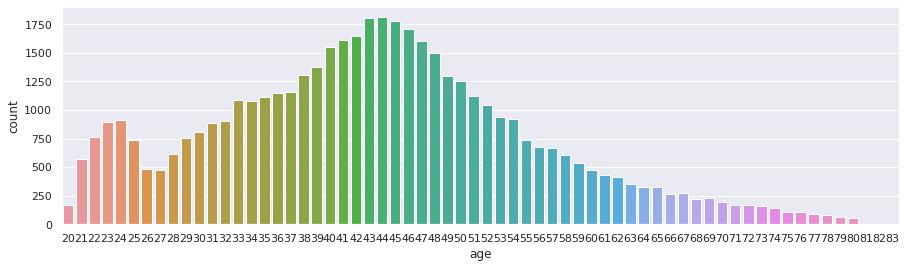

In [76]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'age', data = df4[df4['response'] == 1]);

#### H3: The place of residence influences the decision to take out car insurance.

##### The hypothesis is TRUE. Some regions have a more concentration of car insurance interest.

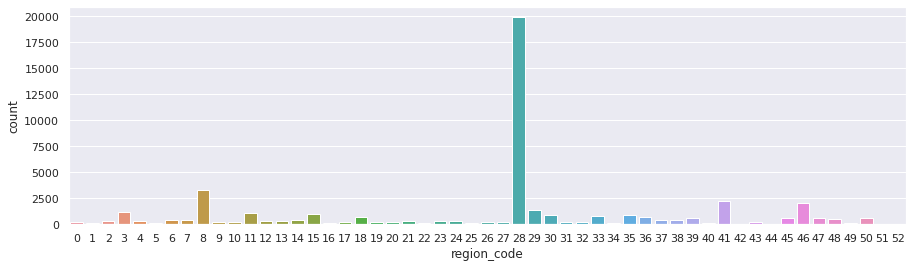

In [77]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'region_code', data = df4[df4['response'] == 1]);

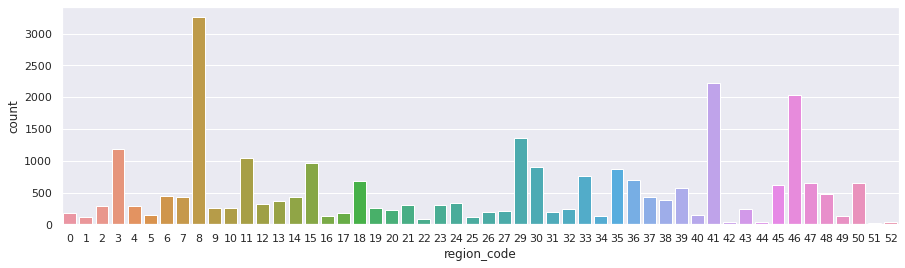

In [78]:
aux = df4[(df4['region_code'] != 28) & (df4['response'] == 1)]
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'region_code', data = aux);

#### H4: People who have had damage to their cars are more likely to take out car insurance.

##### The hypothesis is TRUE. When happened car damage, there is car insurance interest.

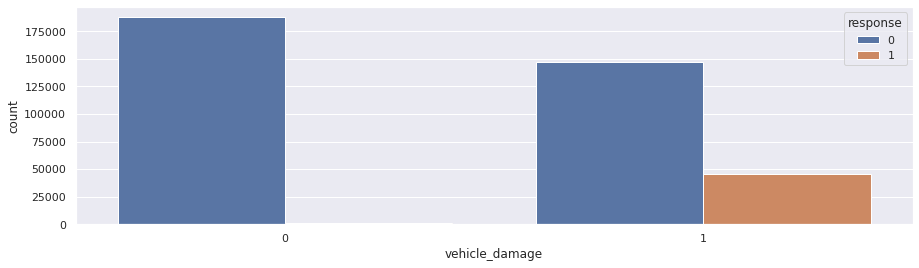

In [79]:
fig, axs = plt.subplots(figsize = (15,4))
sns.countplot(x = df4['vehicle_damage'], hue = df4['response']);

#### H5: People who already have car insurance are more likely to purchase a new policy.

##### The hypothesis is FALSE. The consumers that already have car insurance don't have an interest in a new policy.

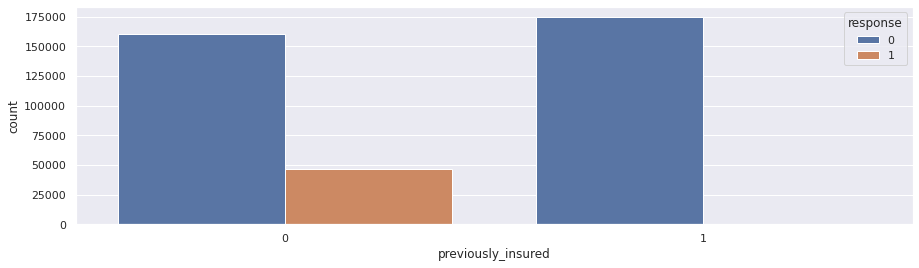

In [80]:
fig, axs = plt.subplots(figsize = (15,4))
sns.countplot(x = df4['previously_insured'], hue = df4['response']);

#### H6: People with newer vehicles are more likely to take out car insurance.

##### The hypothesis is FALSE. The interest in car insurance is concentrate between owners of vehicles with 1 and 2 years old.

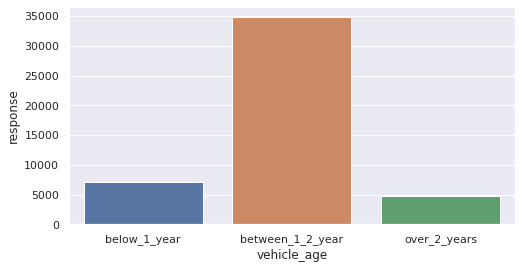

In [81]:
new_vehi = df4.loc[df4['response'] == 1].groupby('vehicle_age').count().reset_index()
fig = plt.subplots(figsize = (8,4))
sns.barplot(x = 'vehicle_age', y = 'response', data = new_vehi);

#### H7: Customers with a longer relationship with the insurance company are more likely to take out a new product.

##### The hypothesis is FALSE. There is no relationship between when the customer bought their health insurance and interest in car insurance.


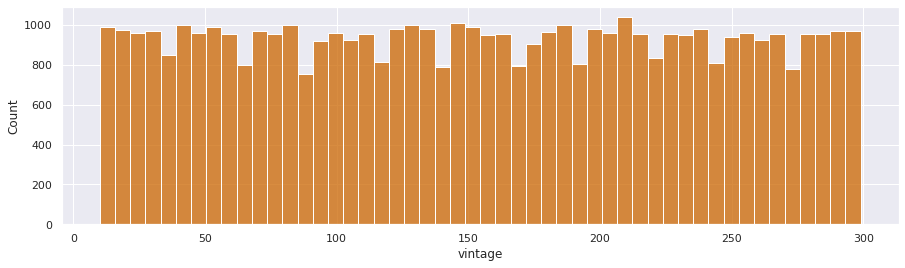

In [82]:
fig = plt.subplots(figsize = (15,4))
sns.histplot(x = 'vintage', bins = 50, data = df4.loc[df4['response'] == 1], color = o_orange);

#### H8: Customers with higher health insurance expenses are more likely to purchase a new product.

##### The hypothesis is FALSE. There is a concentration of positive answers around of mean of annual premiums paid.


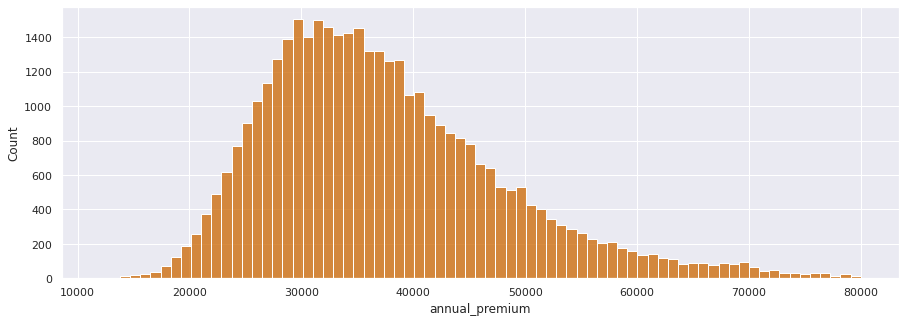

In [83]:
# annual_premium
ann_pre = df4.loc[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
ann_pre = ann_pre.loc[ann_pre['response'] == 1, 'annual_premium']

fig = plt.subplots(figsize = (15,5))
sns.histplot(ann_pre, bins = 75, color = o_orange);

### 4.2.1 Hyphotesis resume

In [84]:
tab =[['Hyphotesis', 'Conclusion', 'Relevace'],
      ['H1',         'False',      'Average'],
      ['H2',         'False',      'High'],
      ['H3',         'True',       'High'],
      ['H4',         'True',       'Low'],
      ['H5',         'False',      'Average'],
      ['H6',         'False',      'High'],
      ['H7',         'False',      'Low'],
      ['H8',         'False',      'High']]

print(tabulate(tab, headers='firstrow'))

Hyphotesis    Conclusion    Relevace
------------  ------------  ----------
H1            False         Average
H2            False         High
H3            True          High
H4            True          Low
H5            False         Average
H6            False         High
H7            False         Low
H8            False         High


## 4.3 Multivariate Analysis

In [85]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'damage_per_rcode'],
      dtype='object')

In [86]:
df4.dtypes

id                        int64
gender                    int64
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage            int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
damage_per_rcode        float64
dtype: object

In [87]:
# Numerical attributes
num_attributes = df4[['age', 'annual_premium', 'vintage']]

# Updating categorical attributes
cat_attributes = df4[['gender', 'region_code', 'policy_sales_channel', 'previously_insured', 'driving_license', 'vehicle_age', 'vehicle_damage', 'damage_per_rcode', 'response']]

# Target
# target_atribute = df4['response']

### 4.3.1 Numerical Attributes

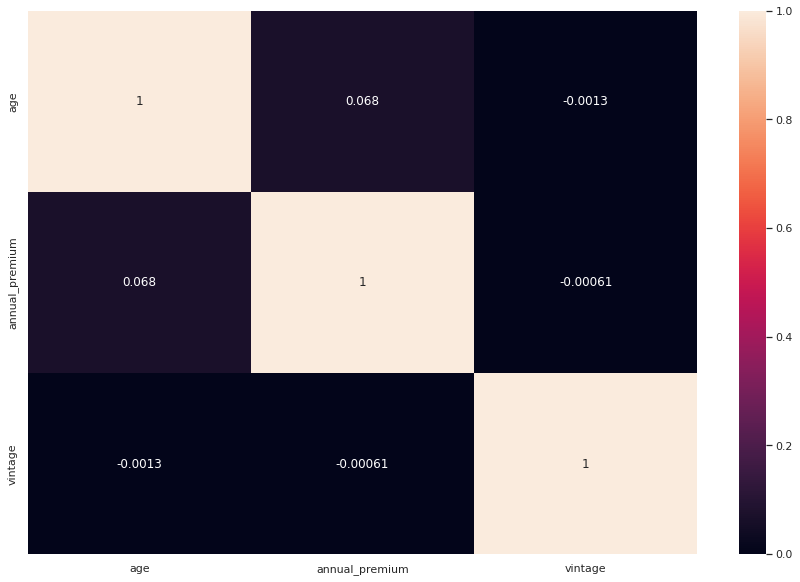

In [88]:
correlation = num_attributes.corr(method = 'pearson')
fig = plt.subplots(figsize = (15, 10))
sns.heatmap(correlation, annot = True);

### 4.3.2 Categorical Attributes

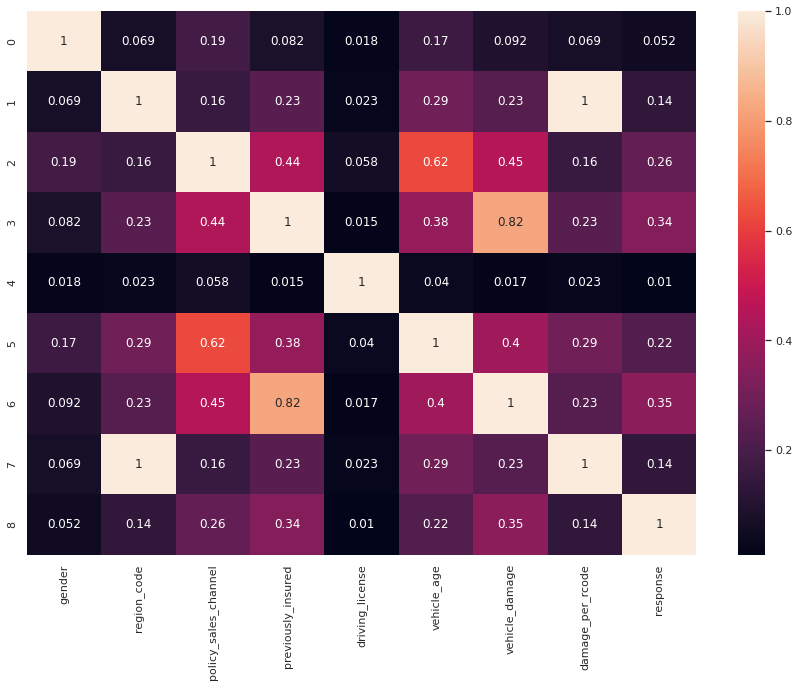

In [89]:
fig = plt.subplots(figsize = (15,10))
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot = True);

In [90]:
# due to high correlations
cols_selected_eda = ['vehicle_damage', 'policy_sales_channel', 'vehicle_age', 'previously_insured', 'response']

In [91]:
df4.to_pickle(r"../data/interim/df4.pkl")

# 5.0 Data Preparation

In [92]:
#df5 = pd.read_csv('../data/interim/df4.csv')
df5 = pd.read_pickle(r"../data/interim/df4.pkl")

In [93]:
df5.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'damage_per_rcode'],
      dtype='object')

In [94]:
# splitting the train dataset in train and validation
X = df5.drop('response', axis=1)
y = df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.20)

df5 = pd.concat([x_train, y_train], axis=1)

In [95]:
shape(y_train)

(304887,)

## 5.1 Standardization

In [96]:
df5[['annual_premium']].values

array([[27488.],
       [35354.],
       [44935.],
       ...,
       [29289.],
       [31735.],
       [ 2630.]])

In [97]:
# annual_premium -> to be already like a normal distribution, in the first cycle the outliers will be maintained
ss = pp.StandardScaler()

df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
#df5['annual_premium']
# saving pickles to deploy
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))

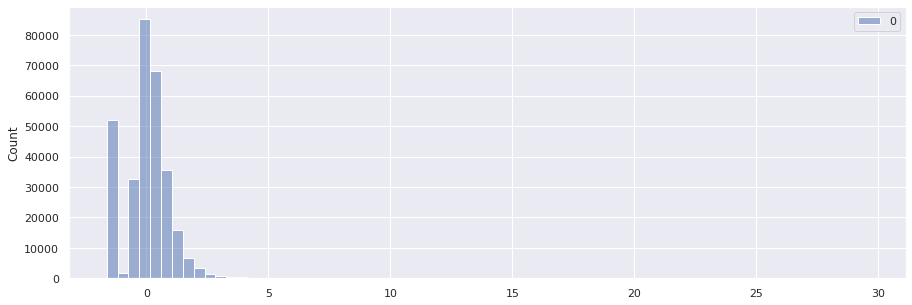

In [98]:
fig = plt.subplots(figsize = (15,5))
sns.histplot(df5[['annual_premium']].values, bins = 70);

## 5.2 Rescaling

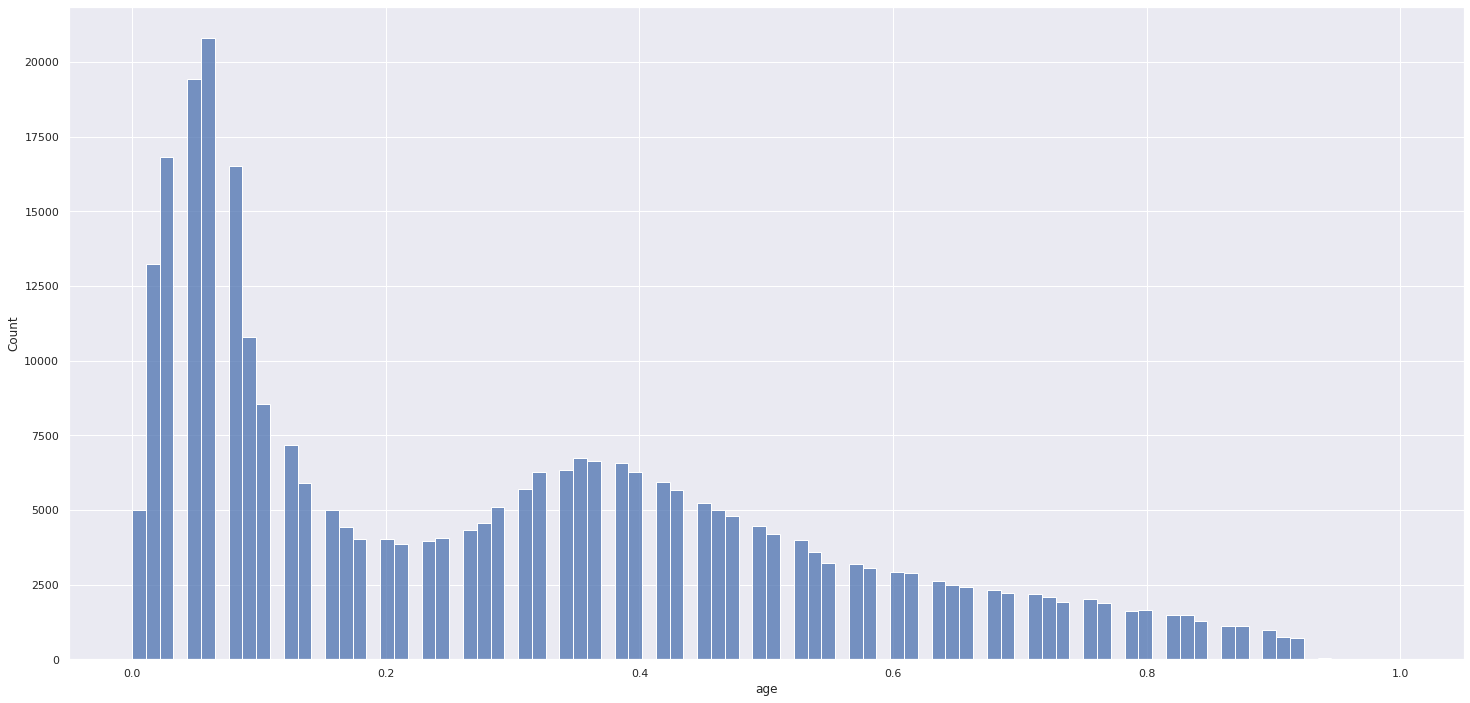

In [99]:
# Age -> because it isn't a normal distribution
mms_age = pp.MinMaxScaler()

df5['age'] = mms_age.fit_transform(df5[['age']].values)

# saving the pickles to deploy
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

sns.histplot(df5['age']);

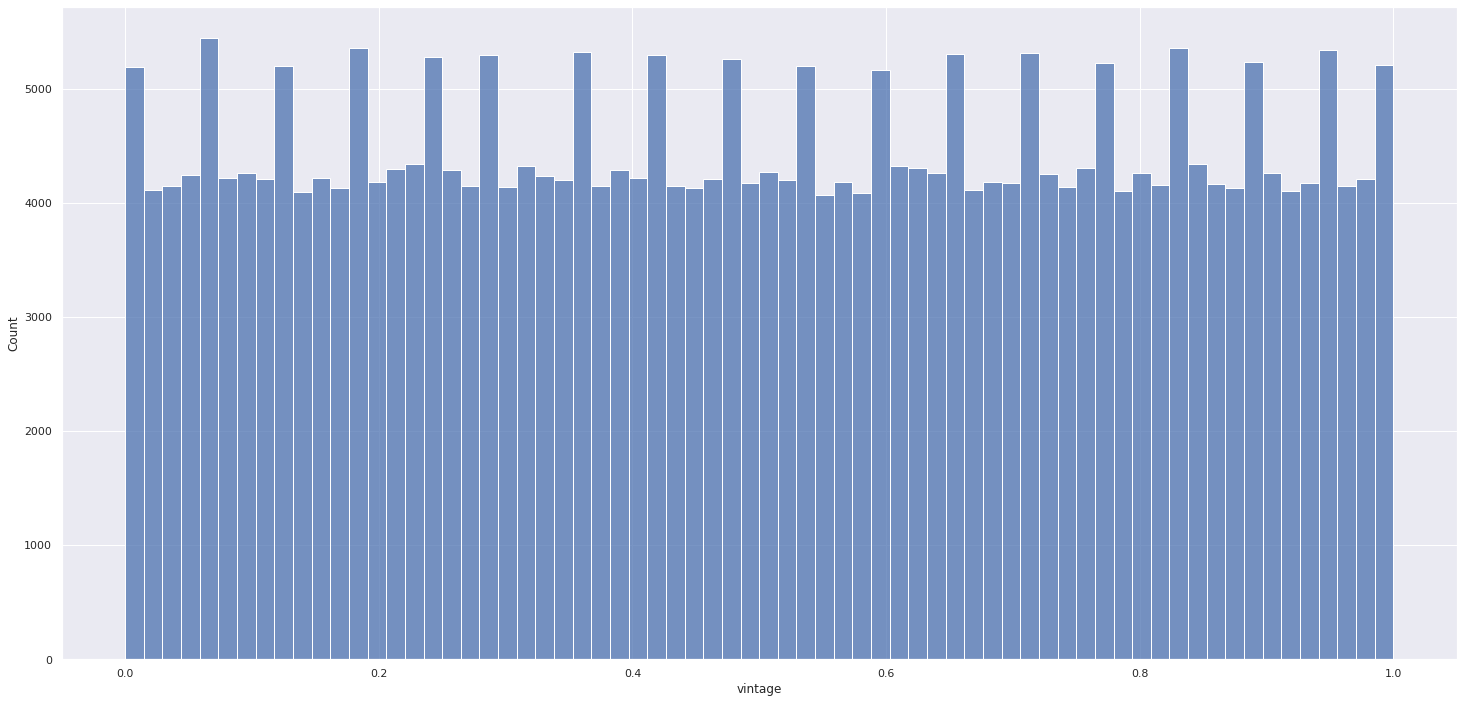

In [100]:
# vintage
mms_vintage = pp.MinMaxScaler()

df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

# saving the pickles to deploy
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

sns.histplot(df5['vintage']);

## 5.3 Transformation

### 5.3.1 Encoding

In [101]:
# driving_license: its already a code (0 or 1 -> label encoding)
# previously_insured: its already a code (0 or 1 -> label encoding)
# vehicle_damage: its already a code (0 or 1 -> label encoding)

In [102]:
# gender - One hot encoding / **Target encoding**
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# saving the pickles to deploy
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl', 'wb'))

#target_encode_gender
#df5['gender']

In [103]:
# region_code (it has to much levels) - **Target Encoding**/ Frequency Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# saving the pickles to deploy
pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl', 'wb'))

#target_encode_region_code
#iidf5['region_code']

In [191]:
# vehicle_age: if considered only two year as double of one year, cars that are 14 months old aren't doubly old 
# than a car with 6 months (**One hot Encoding**/ Order Encoding/ Frequency Encoding)
#df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])
#df5 = df_aux

target_encode_vehicle_age = df5.groupby ('vehicle_age')['response'].mean()
df5.loc[:, 'vehicle_age'] = df5['vehicle_age'].map(target_encode_vehicle_age)
pickle.dump(target_encode_vehicle_age, open('../src/features/vehicle_age_scaler.pkl', 'wb'))

#df_aux

In [105]:
# policy_sales_channel: Targer Enconding/ **Frequency Encoding**
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# saving the pickles to deploy
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

#fe_policy_sales_channel
#df5['policy_sales_channel']

## 5.4 Preparation of Validation

In [192]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# age (applying just transform metho, so it don't add new measures of mean an std values to the feature that are different of the training dataset)
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
# x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])
x_validation.loc[:, 'vehicle_age'] = x_validation.loc[:, 'vehicle_age'].map(target_encode_vehicle_age)

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna -> if there is any value that is on validation but is not in train dataset
x_validation = x_validation.fillna(0)

In [107]:
# df5.to_csv('../data/interim/df5.csv', index=False)
df5.to_pickle(r"../data/interim/df5.pkl")

# 6.0 Feature Selection

In [108]:
# df6 = pd.read_csv('../data/interim/df5.csv')
df6 = pd.read_pickle(r"../data/interim/df5.pkl")

## 6.1 Split Dataframe

In [109]:
# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

## 6.2 Boruta Algorithm

In [110]:
# Define model
#et = en.ExtraTreesClassifier(n_jobs = -1)

# Define boruta
#boruta = bt.BorutaPy(et, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

In [111]:
# cols_selected = boruta.support_.tolist()
# 
# # best features
# x_train_fs = df6.drop(['id', 'response'], axis = 1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
# 
# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))
# 
# cols_selected_boruta

## 6.3 Features Importance

In [112]:
# # model definition
# forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)
# 
# x_train_n = df6.drop(['id', 'response'], axis=1)
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n);

In [113]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]
# 
# # Print the feature ranking
# print("Feature ranking:")
# df = pd.DataFrame()
# for i, j in zip( x_train_n, forest.feature_importances_ ):
#     aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
#     df = pd.concat( [df, aux], axis=0 )
#     
# print( df.sort_values( 'importance', ascending=False ) )
# 
# # Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()

<h3>Selected Columns:</h3>

<ul><strong>From EDA</strong>
    <ul>
        <li>vehicle_damage</li>
        <li>policy_sales_channel</li>
        <li>vehicle_age</li>
        <li>previously_insured</li>
        <li>response</li>
    </ul>
</ul>
                      
<ul><strong>From Boruta</strong>
    <ul>
        <li>age</li>
    </ul>
</ul>

<ul><strong>From Features Importance</strong>
    <ul>
        <li>vintage</li>
        <li>annual_premium</li>
        <li>age</li>
        <li>vehicle_damage</li>
        <li>policy_sales_channel</li>
        <li>previously_insured</li>
        <li>region_code</li>
        <li>damage_per_rcode</li>
    </ul>
</ul>

<h3>Features final list:</h3>
    <ol>
        <li>vehicle_damage</li>
        <li>policy_sales_channel</li>
        <li>vehicle_age</li>
        <li>previously_insured</li>
        <li>vintage</li>
        <li>annual_premium</li>
        <li>age</li>
        <li>region_code</li>
        <li>damage_per_rcode</li>
    </ol>

In [114]:
# df6.to_csv('../data/interim/df6.csv', index=False)
df6.to_pickle(r"../data/interim/df6.pkl")

# 7.0 Machine Learning

In [115]:
# df7 = pd.read_csv('../data/interim/df6.csv')
df7 = pd.read_pickle(r"../data/interim/df6.pkl")

In [116]:
cols_selected_importance = ['vintage', 
                            'annual_premium', 
                            'age', 
                            'region_code', 
                            'vehicle_damage', 
                            'policy_sales_channel',
                            'previously_insured',
                            'vehicle_age',
                            'damage_per_rcode']

In [117]:
x_train = df7[cols_selected_importance]

x_val = x_validation[cols_selected_importance]
y_val = y_validation

## 7.1 KNN Classifier

In [118]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalization
yhat_knn = knn_model.predict_proba(x_val)

Because the problem is a ordened list we need some metrics of ordenation

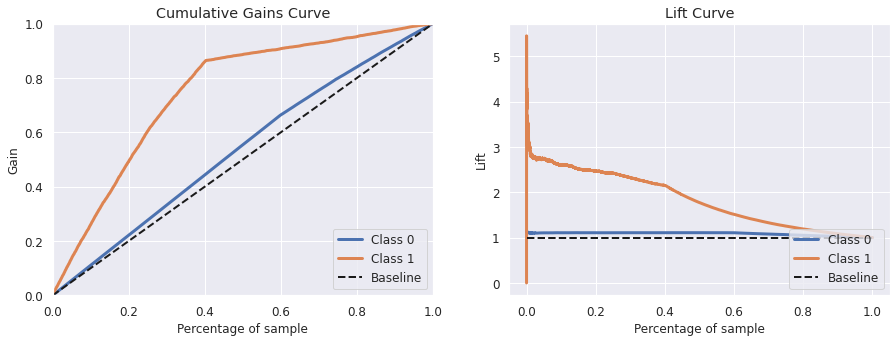

In [119]:
# Accumulative Gain
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax = axs[1]);

In [120]:
# Performance

# compute precision at k
knn_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_knn, 25000), 3)
print('KNN Model - Precision at K: {}'.format(knn_precision_at_k))

# compute Recall at k
knn_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_knn, 25000), 3)
print('KNN Model - Recall at K: {}'.format(knn_recall_at_k))

KNN Model - Precision at K: 0.277
KNN Model - Recall at K: 0.742


### KNN - Cross Validation

In [121]:
knn_cv  = cross_validation (df7, 5, 'KNN CV', knn_model, x_train, y_train, 20000)

In [122]:
rp_knn_cv = pd.DataFrame.from_dict(knn_cv, orient='index').T

## 7.2 Logistic Regression

In [123]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

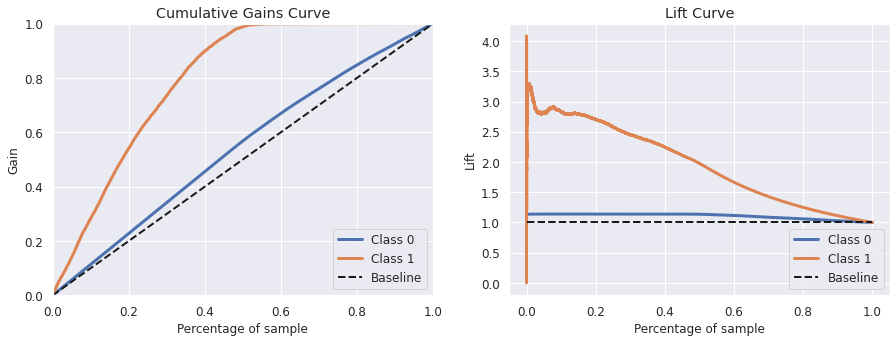

In [124]:
# Accumulative Gain
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax = axs[1]);

In [125]:
# Performance

# compute precision at k
lr_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_lr, 25000), 3)
print('LRegression Model - Precision at K: {}'.format(lr_precision_at_k))

# compute Recall at k
lr_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_lr, 25000), 3)
print('LRegression Model - Recall at K: {}'.format(lr_recall_at_k))

LRegression Model - Precision at K: 0.294
LRegression Model - Recall at K: 0.788


### 7.2.1 Logistic Regression - Cross Validation

In [126]:
lr_cv  = cross_validation (df7, 5, 'LRegression CV', lr_model, x_train, y_train, 20000)

In [127]:
rp_lr_cv = pd.DataFrame.from_dict(lr_cv, orient='index').T

## 7.3 Extra Trees Classifier

In [128]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=14)

# model training
et.fit(x_train, y_train)

# model prediction
yhat_et = et.predict_proba(x_val)

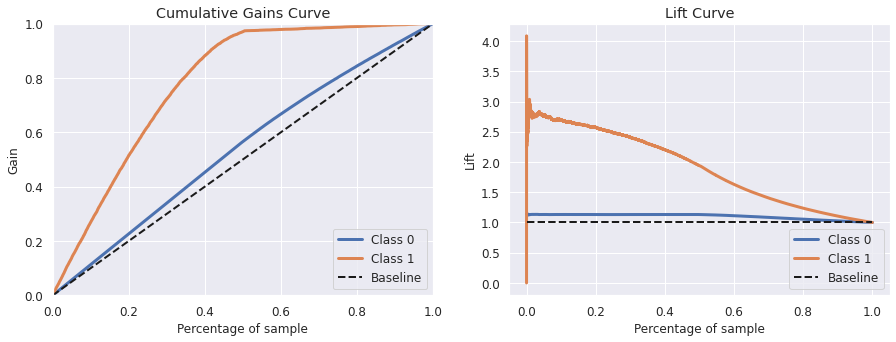

In [129]:
# Accumulative Gain
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, ax = axs[0]);
skplt.metrics.plot_lift_curve(y_val, yhat_et, ax = axs[1]);

In [130]:
# Performance

# compute precision at k
et_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_et, 25000), 3)
print('ETrees Model - Precision at K: {}'.format(et_precision_at_k))

# compute Recall at k
et_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_et, 25000), 3)
print('ETrees Model - Recall at K: {}'.format(et_recall_at_k))

ETrees Model - Precision at K: 0.289
ETrees Model - Recall at K: 0.773


### 7.3.1 Extra Tress - Cross Validation

In [131]:
et_cv  = cross_validation (df7, 5, 'ETrees CV', et, x_train, y_train, 20000)

In [132]:
rp_et_cv = pd.DataFrame.from_dict(et_cv, orient='index').T

## 7.4 Random Forest

In [133]:
# model definition
rf = en.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=14) 

# model training
rf.fit(x_train, y_train)

# model prediction
yhat_rf = et.predict_proba(x_val)

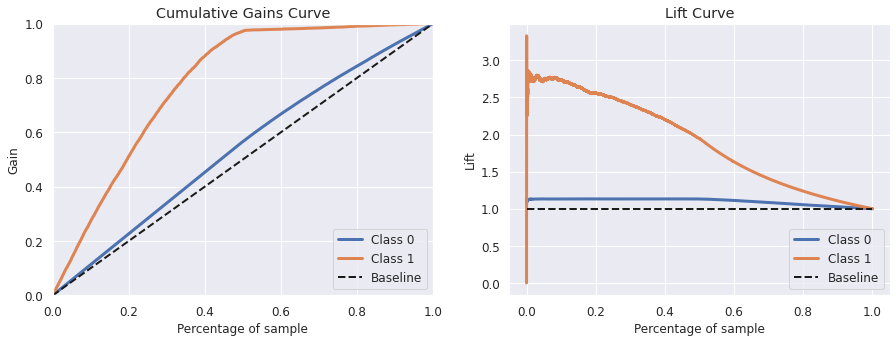

In [134]:
# Accumulative Gain
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_rf, ax = axs[1]);

In [135]:
# Performance

# compute precision at k
rfc_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_rf, 25000), 3)
print('RFC Model - Precision at K: {}'.format(rfc_precision_at_k))

# compute Recall at k
rfc_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_rf, 25000), 3)
print('RFC Model - Recall at K: {}'.format(rfc_recall_at_k))

RFC Model - Precision at K: 0.288
RFC Model - Recall at K: 0.771


### 7.4.1 Random Forest - Cross Validation

In [136]:
rfc_cv  = cross_validation (df7, 5, 'RForest CV', rf, x_train, y_train, 20000)

In [137]:
rp_rfc_cv = pd.DataFrame.from_dict(rfc_cv, orient='index').T

## 7.5 XGBoost Classifier

In [138]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'error')

xgb_model.fit(x_train,y_train)

yhat_xgb = xgb_model.predict_proba(x_val)

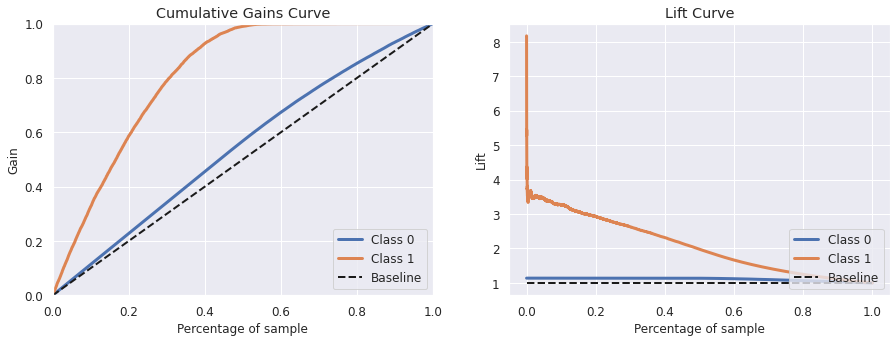

In [139]:
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, ax = axs[1]);

In [140]:
# Performance

# compute precision at k
xgb_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_xgb, 25000), 3)
print('RFC Model - Precision at K: {}'.format(xgb_precision_at_k))

# compute Recall at k
xgb_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_xgb, 25000), 3)
print('RFC Model - Recall at K: {}'.format(xgb_recall_at_k))

RFC Model - Precision at K: 0.31
RFC Model - Recall at K: 0.832


### 7.5.1 XGBoost - Cross Validation

In [141]:
xgb_cv  = cross_validation (df7, 5, 'XGB CV', xgb_model, x_train, y_train, 20000)

In [142]:
rp_xgb_cv = pd.DataFrame.from_dict(xgb_cv, orient='index').T

## 7.6 Compare model's Performance

### 7.6.1 Single Performance

In [143]:
m_perf_dict = {
'Model Name'      : ['KNN', 'LRegression', 'Etrees', 'RForest', 'XGB'],
'Precision_at_k': [knn_precision_at_k, lr_precision_at_k, et_precision_at_k, rfc_precision_at_k, xgb_precision_at_k],
'Recall_at_k': [knn_recall_at_k, lr_recall_at_k, et_recall_at_k, rfc_recall_at_k, xgb_recall_at_k]}

m_performance_sp = pd.DataFrame(m_perf_dict).sort_values('Recall_at_k', ascending = False).reset_index(drop = True)
m_performance_sp

,Model Name,Precision_at_k,Recall_at_k
0,XGB,0.310,0.832
1,LRegression,0.294,0.788
2,Etrees,0.289,0.773
3,RForest,0.288,0.771
4,KNN,0.277,0.742


### 7.6.2 Real Performance - Cross Validation

In [144]:
models_performance_cv = pd.concat([rp_knn_cv, rp_lr_cv, rp_et_cv, rp_rfc_cv, rp_xgb_cv]).sort_values('Recall_at_k', ascending = False).reset_index(drop = True)
models_performance_cv

,Model Name,Precision_at_k,Recall_at_k
0,XGB CV,0.309 +/- 0.001,0.828 +/- 0.003
1,LRegression CV,0.294 +/- 0.003,0.787 +/- 0.007
2,RForest CV,0.292 +/- 0.002,0.78 +/- 0.006
3,ETrees CV,0.285 +/- 0.001,0.763 +/- 0.005
4,KNN CV,0.278 +/- 0.001,0.743 +/- 0.002


In [145]:
df7.to_pickle(r"../data/interim/df7.pkl")

# 8.0 Hyperparameter fine tuning

In [146]:
df8 = pd.read_pickle(r"../data/interim/df7.pkl")

## 8.1 Random Search

In [147]:
param = { 'objective'        : ['binary:logistic'],
          'eval_metric'      : ['error'],
          'n_estimators'     : [500, 750, 1000], 
          'eta'              : [0.01, 0.05, 0.09],
          'max_depth'        : [1, 5, 9],
          'subsample'        : [0.1, 0.5, 0.9],
          'colsample_bytree' : [0.1, 0.5, 0.9],
          'min_child_weight' : [3, 12, 20] 
        }

MAX_EVAL = 10

In [148]:
# final_result = pd.DataFrame({'Model Name':[], 'Precision_at_k': [], 'Recall_at_k': []})

In [149]:
# for i in range (MAX_EVAL):
#     hp = {w: random.sample(v, 1) [0] for w, v in param.items()}
#     print ('Step ' + str(i + 1) + '/' + str(MAX_EVAL))
#     print (hp)
#     
#     model_xgb = xgb.XGBClassifier(
#                 objective = hp['objective'],
#                 eval_metric = hp['eval_metric'],
#                 n_estimators = hp['n_estimators'], 
#                 eta = hp['eta'], 
#                 max_depth = hp['max_depth'], 
#                 subsample = hp['subsample'],
#                 colsample_bytree = hp['colsample_bytree'],
#                 min_child_weight = hp['min_child_weight'])
#     
#     result = cross_validation (df8, 5, 'XGBoost FT', model_xgb, x_train, y_train, 20000)
#     result = pd.DataFrame.from_dict(result, orient='index').T
#     final_result = pd.concat([final_result, result])
#     
# final_result = pd.DataFrame(final_result)

In [150]:
# final_result.reset_index(drop = True)

In [151]:
# final_res = final_result.sort_values('Recall_at_k', ascending = False)
# final_res 

## 8.2 Final Model

In [152]:
xgb_param_tuned = {'objective': 'binary:logistic', 
                   'eval_metric': 'error', 
                   'n_estimators': 750, 
                   'eta': 0.05, 
                   'max_depth': 5, 
                   'subsample': 0.5, 
                   'colsample_bytree': 0.9, 
                   'min_child_weight': 20
                  }

In [153]:
model_xgb_tuned = xgb.XGBClassifier (
    objective = xgb_param_tuned['objective'],
    eval_metric = xgb_param_tuned['eval_metric'],
    n_estimators = xgb_param_tuned['n_estimators'], 
    eta = xgb_param_tuned['eta'], 
    max_depth = xgb_param_tuned['max_depth'], 
    subsample = xgb_param_tuned['subsample'],
    colsample_bytree = xgb_param_tuned['colsample_bytree'],
    min_child_weight = xgb_param_tuned['min_child_weight'])

model_xgb_tuned.fit(x_train, y_train)

yhat_xgb_tuned = model_xgb_tuned.predict_proba(x_val)

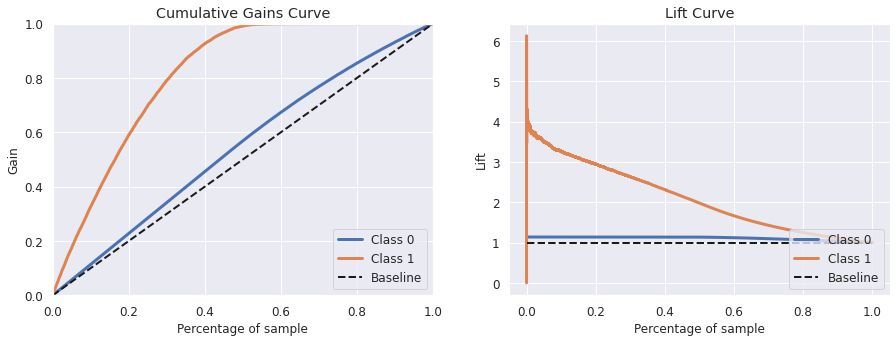

In [154]:
# Accumulative Gain
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb_tuned, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_xgb_tuned, ax = axs[1]);

In [155]:
# Compute Recall at k
xgb_recall_at_20000 = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 20000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))

XGB Model - Recall at K: 0.832


# 9.0 Error Interpretation

## 9.1 Machine Learning - Test Dataset

In [156]:
df_test = pd.read_csv('/home/work/Documents/repos/pa004_health_insurance_cross_sell/cfdo_health_insurance_cross_sell/health_insurance_cross_sell_gitlab/archive/data/external/test.csv')
df_test_raw = df_test.copy()

In [157]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [158]:
# PREPARING TEST DATASET

cols_old = df_test.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df_test.columns = cols_new

# Change datatypes

df_test['region_code'] = df_test['region_code'].astype('int64')
df_test['policy_sales_channel'] = df_test['policy_sales_channel'].astype('int64')
df_test.dtypes

# Feture Engineering

df_test['vehicle_damage'] = df_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
df_test['vehicle_age'] = df_test['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year'  else 'below_1_year')
df_test['gender'] = df_test['gender'].apply( lambda x: 1 if x == 'Female' else 0)
damage_per_rcode = df_test[['vehicle_damage']].groupby(df_test['region_code']).mean().reset_index()
damage_per_rcode = damage_per_rcode.rename( columns = {'vehicle_damage' : 'damage_per_rcode'})
df_test = df_test.merge(damage_per_rcode, on = 'region_code', how = 'left')
df_test['damage_per_rcode'] = df_test['damage_per_rcode'].astype(np.float64)

# Encoding

df_test.loc[:, 'gender'] = df_test.loc[:, 'gender'].map(target_encode_gender)
df_test.loc[:, 'age'] = mms_age.transform(df_test[['age']].values)
df_test.loc[:, 'region_code'] = df_test.loc[:, 'region_code'].map(target_encode_region_code)
df_test.loc[:, 'vehicle_age'] = df_test.loc[:, 'vehicle_age'].map(target_encode_vehicle_age)
df_test.loc[:, 'annual_premium'] = ss.transform(df_test[['annual_premium']].values)
df_test.loc[:, 'policy_sales_channel'] = df_test['policy_sales_channel'].map(fe_policy_sales_channel)
df_test.loc[:, 'vintage'] = mms_vintage.transform(df_test[['vintage']].values)
df_test = df_test.fillna(0)

# Select columns to apply the machine learning algorithm

cols_selected_importance = ['vintage', 
                            'annual_premium', 
                            'age', 
                            'region_code', 
                            'vehicle_damage', 
                            'policy_sales_channel',                                               'previously_insured',
                            'vehicle_age',
                            'damage_per_rcode']

df_test_f = df_test[cols_selected_importance]
yhat_xgb_tuned = model_xgb_tuned.predict_proba(df_test_f)

# Make the prediction

df_predict = df_test_raw.copy()
df_predict['score'] = yhat_xgb_tuned[:,1].tolist()
df_predict = df_predict.sort_values('score', ascending = False).reset_index()
df_predict['ranking'] = df_predict.index + 1
df_predict.head(5)

,index,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score,ranking
0,106366,487476,Male,44,1,28.0,0,< 1 Year,Yes,29259.0,26.0,121,0.658285,1
1,88346,469456,Male,46,1,28.0,0,> 2 Years,Yes,84786.0,26.0,175,0.654432,2
2,72692,453802,Male,46,1,28.0,0,< 1 Year,Yes,52928.0,26.0,145,0.649018,3
3,40448,421558,Male,48,1,18.0,0,< 1 Year,Yes,36566.0,26.0,178,0.642367,4
4,113093,494203,Female,43,1,41.0,0,< 1 Year,Yes,29754.0,26.0,258,0.641355,5


## 9.2 Business Performance

### 9.2.1 Percentage of clients interested in vehicle insurance that will be contacted with 20.000 calls.

In [159]:
# getting the percentage provided by the algorithm based on test dataset
calls = 20000
total_leads = df_test.shape[0]
perc_calls = calls / total_leads
print('Total leads: {}'.format(total_leads))
print('% of calls: {0:.2f}%'.format(perc_calls*100))

Total leads: 127037
% of calls: 15.74%


In [160]:
# applying the percentage provided (15.74) on validation dataset (20% of total dataset) to estimate the recall@k
validation_leads = x_val.shape[0]
call_validation_leads = validation_leads * perc_calls
print('Total validation leads: {}'.format(validation_leads))
print('number of calls: {0:.2f}'.format(call_validation_leads))

Total validation leads: 76222
number of calls: 11999.97


In [161]:
# rounding the number of calls to 12000 to Compute Recall at k based on the validation dataset and previous yhat_xgb
xgb_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 12000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))
print('Percentage of customers interested: {}%'.format(xgb_recall_at_k*100))

XGB Model - Recall at K: 0.479
Percentage of customers interested: 47.9%


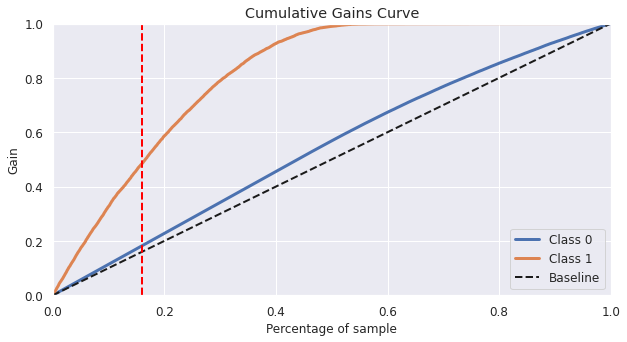

In [162]:
# rounding the % off calls to 16%
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, figsize = (10, 5))
plt.axvline(0.16, 0, 1, color = 'red', ls = '--', lw = 2);

### 9.2.2 Percentage of clients interested in vehicle insurance that will be contacted with 40.000 calls.

In [163]:
# getting the percentage provided by the algorithm based on test dataset
calls = 40000
total_leads = df_test.shape[0]
perc_calls = calls / total_leads
print('Total leads: {}'.format(total_leads))
print('% of calls: {0:.2f}%'.format(perc_calls*100))

Total leads: 127037
% of calls: 31.49%


In [164]:
# applying the percentage provided (15.74) on validation dataset (20% of total dataset) to estimate the recall@k
validation_leads = x_val.shape[0]
call_validation_leads = validation_leads * perc_calls
print('Total validation leads: {}'.format(validation_leads))
print('number of calls: {0:.2f}'.format(call_validation_leads))

Total validation leads: 76222
number of calls: 23999.94


In [165]:
# rounding the number of calls to 24000 to Compute Recall at k based on the validation dataset and previous yhat_xgb
xgb_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 24000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))
print('Percentage of customers interested: {}%'.format(xgb_recall_at_k*100))

XGB Model - Recall at K: 0.813
Percentage of customers interested: 81.3%


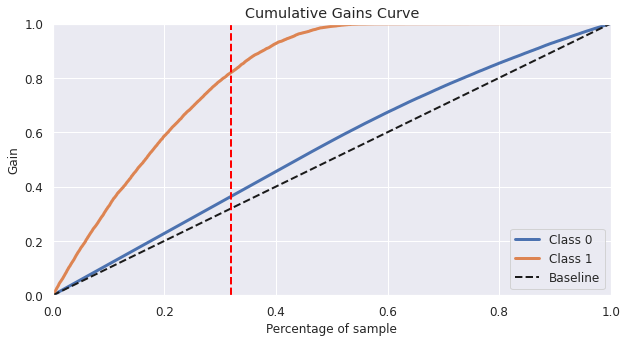

In [166]:
# rounding the % off calls to 32%
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, figsize = (10, 5))
plt.axvline(0.32, 0, 1, color = 'red', ls = '--', lw = 2);

### 9.2.3 Number of calls to contact 80% of clients interested in vehicle insurance. (23369 calls)

In [173]:
# estimating the number of calls based on model performance in validation dataset
df9 = x_validation.copy()
df9['response'] = y_validation.copy()
df9['score'] = yhat_xgb[:, 1].tolist()
df9 = df9.sort_values('score', ascending = False)
df9 = df9.reset_index(drop = True)
df9['ranking'] = df9.index + 1
df9['recall_at_k'] = df9['response'].cumsum() / df9['response'].sum()
calls_at_80 = df9[df9['recall_at_k'] <= 0.8]
calls_at_80.tail(1)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,damage_per_rcode,response,score,ranking,recall_at_k
23368,234889,0.104054,0.676923,0.113627,0.193924,1,0.173969,1,0,-1.619725,0.307958,0.357777,0,0.204187,23369,0.799914


### 9.2.4 ROI Curve Manually

In [188]:
results = pd.DataFrame()
results['prediction'] = yhat_xgb[:,1].tolist()

# Compute bucket
results['bucket'] = results['prediction'].apply(lambda x: 
                                                
                0.9 if x >= 0.90 else                               
                0.8 if (x >= 0.80) & (x < 0.90) else                        
                0.7 if (x >= 0.70) & (x < 0.80) else                                 
                0.6 if (x >= 0.60) & (x < 0.70) else                              
                0.5 if (x >= 0.50) & (x < 0.60) else                                
                0.4 if (x >= 0.40) & (x < 0.50) else                                
                0.3 if (x >= 0.30) & (x < 0.40) else                                
                0.2 if (x >= 0.20) & (x < 0.30) else                                 
                0.1 if (x >= 0.10) & (x < 0.20) else 0.01)

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby('bucket').agg({'min', 'count'}).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']
df['base'] = df['clients'].sort_values(ascending=True).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values('index', ascending=False)
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
8,0.80,2,0.802193,64.175472,8,0.000026,56.175472
7,0.70,17,0.700693,476.471369,68,0.000249,408.471369
6,0.60,44,0.600749,1057.318268,176,0.000827,881.318268
5,0.50,401,0.500195,8023.122487,1604,0.006087,6419.122487
4,0.40,2830,0.400017,45281.916893,11320,0.043216,33961.916893
3,0.30,9964,0.300016,119574.430757,39856,0.280326,79718.430757
2,0.20,10513,0.200017,84111.107165,42052,0.418252,42059.107165
1,0.10,8109,0.100000,32436.012567,32436,0.149602,0.012567
0,0.01,44342,0.000023,40.623769,177368,1.000000,-177327.376231


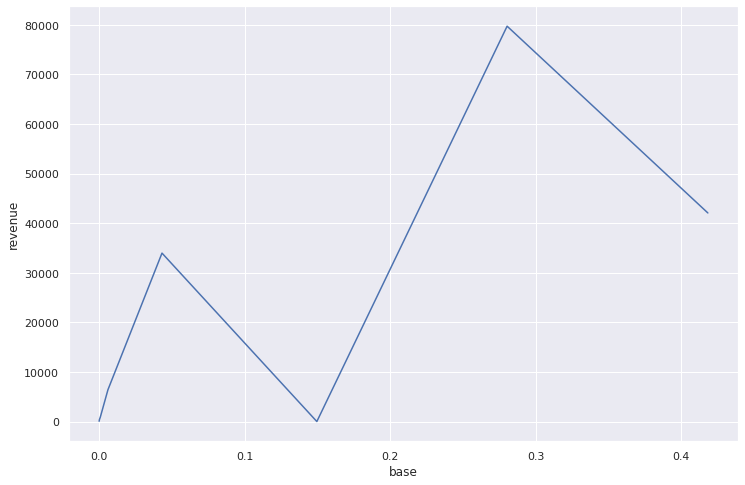

In [189]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot(x='base', y='revenue', data=aux);

Considering the revenu by client convertion at 40 and the const by call at 4, the max roi is provided with 28% of the test dataset.

# 10.0 Deploy to production

In [190]:
# Save trained model
# lr selected due machine processing
pickle.dump(model_xgb_tuned, open('/home/work/Documents/repos/pa004_health_insurance_cross_sell/cfdo_health_insurance_cross_sell/health_insurance_cross_sell_gitlab/archive/src/models/model_xgb_tuned.pkl', 'wb')) # wb -> write bytes

## 10.1 Health Insurance Class

In [193]:
import pickle
import numpy  as np
import pandas as pd
import inflection

class HealthInsurance:
    
    def __init__(self):
        self.home_path = '/home/work/Documents/repos/pa004_health_insurance_cross_sell/cfdo_health_insurance_cross_sell/health_insurance_cross_sell_gitlab/archive/'
        self.annual_premium_scaler = pickle.load(open(self.home_path + 
                            'src/features/annual_premium_scaler.pkl'))
        
        self.age_scaler = pickle.load(open(self.home_path + 
                            'src/features/age_scaler.pkl')) 
        
        self.vintage_scaler = pickle.load(open( self.home_path + 
                            'src/features/vintage_scaler.pkl')) 
        
        self.target_encode_gender_scaler = pickle.load(open(self.home_path + 
                            'src/features/target_encode_gender_scaler.pkl'))
        
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 
                            'src/features/target_encode_region_code_scaler.pkl'))

        self.target_encode_vehicle_age_scaler = pickle.load(open(self.home_path +
                            'src/features/vehicle_age_scaler.pkl'))      
        
        self.fe_policy_sales_channel_scaler = pickle.load(open(self.home_path + 
                            'src/features/fe_policy_sales_channel_scaler.pkl'))
        
    def data_cleaning(self, df1):
        # 1.1. Rename Columns
        cols_old = df1.columns
        snakecase = lambda x: inflection.underscore (x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new
        
        # change types
        df1['region_code'] = df1['region_code'].astype('int64')
        df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')
        
        return df1 

    
    def feature_engineering(self, df2):
        # Vehicle Damage Number - Binary Categorical -> Binary Numeric
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 
                                                 1 if x == 'Yes' else
                                                 0)

        # Vehicle Age
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x:
                            'over_2_years' if x == '> 2 Years' else
                        'between_1_2_year' if x == '1-2 Year'  else
                            'below_1_year')

        # Gender
        df2['gender'] = df2['gender'].apply( lambda x: 1 if x == 'Female' else 0)
        
        damage_per_rcode = df2[['vehicle_damage']].groupby(df2['region_code']).mean().reset_index()
        damage_per_rcode = damage_per_rcode.rename( columns = {'vehicle_damage' : 'damage_per_rcode'})
        df2 = df2.merge(damage_per_rcode, on = 'region_code', how = 'left')
        df2['damage_per_rcode'] = df2['damage_per_rcode'].astype('float64')

        return df2
    
    
    def data_preparation(self, df5):
        # anual premium - StandarScaler
        # aqui a api carrega o pickle com os parâmetros já feitos com o fit anteriormente e aplica através do método transform (não mais fit.transform) nos dados de teste.
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map(self.target_encode_gender_scaler)

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.target_encode_region_code_scaler)

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5.loc[:, 'vehicle_age'] = df5['vehicle_age'].map(target_encode_vehicle_age)
        
        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)
        
        # Feature Selection
        cols_selected = ['vintage', 'annual_premium', 'age', 
                         'region_code', 'policy_sales_channel', 
                         'vehicle_damage', 'previously_insured',
                         'vehicle_age', 'damage_per_rcode']

        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        #original_data['prediction'] = pred
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

Preparing the API to receive the request

In [194]:
import os
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loading model (direct to the memory to make consultant faster)
path = '/home/work/Documents/repos/pa004_health_insurance_cross_sell/cfdo_health_insurance_cross_sell/health_insurance_cross_sell_gitlab/archive/'
model = pickle.load(open(path + 'src/models/model_xgb_tuned.pkl', 'rb'))

# initialize API
app = Flask(__name__)

# rout of call from API, after route is caled hte next function is executed sequencially
@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
                                   # data type, column names   
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    # port = os.environ.get('PORT', 5000) ->  no heroku a porta é passada via variável de ambiente
    app.run('0.0.0.0', debug=True)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on all addresses.
 * Running on http://192.168.0.58:5000/ (Press CTRL+C to quit)
 * Restarting with stat
Traceback (most recent call last):
  File "/home/work/.pyenv/versions/3.8.0/envs/HealthInsurance/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/work/.pyenv/versions/3.8.0/envs/HealthInsurance/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initialize(argv)
  File "/home/work/.pyenv/versions/3.8.0/envs/HealthInsurance/lib/python3.8/site-packages/traitlets/config/application.py", line 88, in inner
    return method(app, *args, **kwargs)
  File "/home/work/.pyenv/versions/3.8.0/envs/HealthInsurance/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 632, in initialize
    self.init_sockets()
  File "/home/work/.pyenv/versions/3.8.0/envs/HealthInsurance/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 282, in init_sockets
    self.shell_port 

SystemExit: 1

## 10.3. API Tester

In [2]:
import requests

In [3]:
# loading test dataset
df_test = x_validation
df_test['response'] = y_validation

NameError: name 'x_validation' is not defined

In [109]:
df_test = df_test.sample(10)
df_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response
283682,361072,0.103344,0.153846,0.121342,0.353718,1,0,1,0.141219,0.965398,1,0,0,0
4090,32761,0.103344,0.092308,0.071085,0.353718,1,0,1,-0.457211,0.245675,1,0,0,0
353533,160790,0.103344,0.030769,0.061205,0.057179,1,1,0,0.340173,0.456747,1,0,0,0
91968,352733,0.138380,0.030769,0.097306,0.353718,1,1,0,-0.130626,0.155709,1,0,0,0
100310,38075,0.138380,0.707692,0.065117,0.208910,1,1,0,-1.619917,0.653979,0,1,0,0
259037,164599,0.138380,0.584615,0.096926,0.194249,1,0,1,1.267102,0.339100,0,1,0,0
24851,198476,0.103344,0.030769,0.121342,0.353718,1,0,1,-0.029264,0.128028,1,0,0,0
205940,120000,0.103344,0.784615,0.186336,0.194249,1,0,0,0.041016,0.114187,0,1,0,0
260871,179297,0.138380,0.030769,0.102524,0.353718,1,0,1,0.453365,0.397924,1,0,0,0
177438,274773,0.138380,0.476923,0.186336,0.208910,1,1,0,0.354380,0.885813,0,0,1,0


In [110]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [111]:
data

'[{"id": 361072, "gender": 0.10334407303952736, "age": 0.15384615384615385, "region_code": 0.12134222121794147, "policy_sales_channel": 0.35371793484143305, "driving_license": 1, "vehicle_damage": 0, "previously_insured": 1, "annual_premium": 0.14121854121833285, "vintage": 0.9653979238754326, "vehicle_age_below_1_year": 1, "vehicle_age_between_1_2_year": 0, "vehicle_age_over_2_years": 0, "response": 0}, {"id": 32761, "gender": 0.10334407303952736, "age": 0.09230769230769231, "region_code": 0.07108519995908766, "policy_sales_channel": 0.35371793484143305, "driving_license": 1, "vehicle_damage": 0, "previously_insured": 1, "annual_premium": -0.4572114161918848, "vintage": 0.24567474048442908, "vehicle_age_below_1_year": 1, "vehicle_age_between_1_2_year": 0, "vehicle_age_over_2_years": 0, "response": 0}, {"id": 160790, "gender": 0.10334407303952736, "age": 0.03076923076923077, "region_code": 0.06120527306967985, "policy_sales_channel": 0.05717856123744207, "driving_license": 1, "vehicle_

In [1]:
# API Call
#url = 'http://0.0.0.0:5000/predict' # localhost for local test
url = 'https://cfo-health-insurance.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

NameError: name 'requests' is not defined

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()